# Analysis and Prediction of Airbnb Listings' Yields in NYC.

Jiaoyu Guo, Yash Jajoo, Renzhi Lin, Hao Gao, Jiawei Fu <br>


## Project Overview
**Our project seeks to solve the problem of predicting the potential yields (annual earnings) of Airbnb listings in New York City by analyzing the data and building a predictive model**. 

For this project, we use the **NYC's dataset provided by Inside Airbnb** (http://insideairbnb.com/get-the-data.html), where publicly available information about a city’s Airbnb listings have been scraped and released for independent, non-commercial use. This includes details about the listing such as room type, description, location, price, no. of reviews, etc. Specifically, **we will use the latest listings.csv file (last scraped by the provider on October 5, 2020)** of the data for NYC listings. 

The project is structured as follows: 
1. **Dataset cleaning and preprocessing** - we fill/remove missing values, perform datatype conversions, derive new features, remove outliers, perform one-hot encoding, etc. 


2. **Dataset Analysis** - We visualise various features of the dataset and discuss their impact on revenue generation.


3. **Machine Learning** - We train 3 models on the dataset for 10 epochs each as well as visualize their loss,  variance score and feature importance. 

In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression

from scipy.stats import gaussian_kde
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = os.path.join(os.getcwd(), 'listings.csv')
df1 = pd.read_csv(path, header=0, index_col=0)
print("The original dataset has {} rows, {} columns.".format(*df1.shape))
df1.head(5)

The original dataset has 45756 rows, 73 columns.


,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2595,https://www.airbnb.com/rooms/2595,20200907203555,2020-09-08,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,...,10.0,10.0,9.0,NaN,f,2,2,0,0,0.37
3831,https://www.airbnb.com/rooms/3831,20200907203555,2020-09-08,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,...,9.0,9.0,9.0,NaN,f,1,1,0,0,4.82
5121,https://www.airbnb.com/rooms/5121,20200907203555,2020-09-08,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,...,10.0,9.0,9.0,NaN,f,1,0,1,0,0.36
5136,https://www.airbnb.com/rooms/5136,20200907203555,2020-09-09,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,https://a0.muscache.com/pictures/a3f7ace8-e7a9...,7378,https://www.airbnb.com/users/show/7378,Rebecca,...,10.0,8.0,10.0,NaN,f,1,1,0,0,0.01
5178,https://www.airbnb.com/rooms/5178,20200907203555,2020-09-08,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,Shunichi,...,9.0,10.0,9.0,NaN,f,1,0,1,0,3.42


# A. Dataset cleaning and preprocessing

**Dropping features**: 


As we can see, there are several unnecessary features such as 'listing_url', 'scrape_id', 'last_scraped', 'name', etc. These features are of no consequence for data analysis, visualisation as well as machine learning and hence we remove them. 


**Data and datatype conversions**: 
1. 'price' is given as a string - we convert it to float. 


2. 'amenities' is given as a string - we first convert it to a list of amenities and then to int (no. of amenities). 


3. 'bathrooms_text' is given as string - we convert it to numerical value (no. of bathrooms) and also derived a new feature 'bath_type" from it that denotes if the bathroom is shared or private. 


4. 'host_response_time' is a categorical feature - We convert it into a numerical feature (no. of hours).


5. 'host_response_rate' is given as a string - we convert it to float. 


6. 'host_verifications' is given as a string - we convert it to an integer (no. of ways the host has been verified) and add it to the dataframe as a new feature 'host_verifications_count' 


7. 'host_since' is given as string - we convert it from string to datetime and then replace it with the no. of years the host has been active. 


**Dealing with missing values**:
1. We fill missing values for "beds' with 1. 1 is used instead of 0 as listings offering no beds are extremely rare.


2. We fill missing values for 'bedrooms' with 0. 0 is used instead of 1 to account for studio apartments which technically have no separate bedrooms. 


3. We fill missing values for 'bathrooms_text' with 1. 1 is used instead of 0 as listings with no bathrooms are extremely rare.


4. we fill missing values for 'host_has_profile_pic' with "f".  


5. we fill missing values for 'host_identity_verified' with "f". 


6. we fill missing values for 'instant_bookable' with "f".


7. We drop rows with missing values in columns: 'reviews_per_month','review_scores_rating','review_scores_accuracy','host_since'


**Deriving features**:
1. 'long term stays' - According to AirBnB, a listing accepts long term stays if the maximum nights guests can stay at that property is at least 28. We derive this using the 'maximum_nights' feature. 


In [3]:
# Dataset cleaning
# Dropping unnecessary columns
filter_list = ['host_since','host_response_time','host_response_rate',
              'host_is_superhost','host_verifications','host_has_profile_pic',
              'host_identity_verified','neighbourhood_group_cleansed',
              'latitude','longitude','room_type','accommodates','bathrooms_text',
              'bedrooms','beds','amenities','price','minimum_nights','maximum_nights','availability_365',
              'number_of_reviews','number_of_reviews_ltm','review_scores_rating','review_scores_accuracy',
              'instant_bookable','reviews_per_month','name']
df = df1[filter_list]

df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df = df[df.price != 0]

#the amenities column for each listing includes a list of amenities which infact is given as a string. Replacing said string into the number of amenities (int) 
amenities_count = []
for item in df['amenities'].values: 
    amenities_count.append(len(item[1:-2].split(",")))
df['amenities_count'] = amenities_count


#removing null values for 'bedrooms' with 0. 0 is used instead of 1 to account for studio apartments which technically have no separate bedrooms.
df['bedrooms'] = df['bedrooms'].fillna(0)

#removing null values for "beds' with 1. 1 is used instead of 0 as listings offering no beds are extremely rare.
df['beds'] = df['beds'].fillna(1)

#removing null values with 1. 1 is used instead of 0 as listings with no bathrooms are extremely rare.
df['bathrooms_text'] = df['bathrooms_text'].fillna(1)

#converting bathrooms_text from string to float. 
#new column 'bath_type' denotes whether the bathroom is shared or private
#one-hot encoding for bath_type: 0 is shared, 1 is Private.
bathrooms_count = []
bath_type = []
for item in df['bathrooms_text'].values:
    if type(item) == str:
        if "half" in item:
            bathrooms_count.append(0.5)
            if('private' in item):
                bath_type.append(1)
            elif('shared' in item):
                bath_type.append(0)
            else:
                bath_type.append(0)
                
        elif "Half" in item:
            bathrooms_count.append(0.5)
            if('private' in item):
                bath_type.append(1)
            elif('shared' in item):
                bath_type.append(0)
            else:
                bath_type.append(0)
                
        else:
            v = re.sub("[^0-9.]", "", item)
            if v == "":
                bathrooms_count.append(1)
                if('private' in item):
                    bath_type.append(1)
                elif('shared' in item):
                    bath_type.append(0)
                else:
                    bath_type.append(0)
            else:
                bathrooms_count.append(float(v))
                if('private' in item):
                    bath_type.append(1)
                elif('shared' in item):
                    bath_type.append(0)
                else:
                    bath_type.append(0)
                
    else:
        bathrooms_count.append(float(item))
        bath_type.append(0)

        
df['bath_type'] = bath_type
df['bathrooms_text'] = bathrooms_count


res_time = []
df['host_response_time'] = df['host_response_time'].fillna('N/A')
for i in df['host_response_time']:
    if i=='N/A':
        res_time.append(72)
    elif i=='a few days or more':
        res_time.append(48)
    elif i=='within a day':
        res_time.append(24)
    elif i=='within a few hours':
        res_time.append(12)
    elif i=='within an hour':
        res_time.append(1)

        
df['host_response_time'] = res_time
res_rate = []
for i in df['host_response_rate'].values:
    if type(i)==str:
        res_rate.append(re.sub("[^0-9.]","",i))
    else:
        res_rate.append(0)
df['host_response_rate'] = res_rate
df['host_response_rate'] = pd.DataFrame(df['host_response_rate'],dtype=np.int)


amenities_list = []
for item in df['amenities'].values: 
    amenities_list.append(item[1:-2].replace('"','').split(","))
    
for amenity in amenities_list:
    for item in amenity:
        stripped = item.replace(item,item.lower().strip())
        amenity[amenity.index(item)] = stripped

df = df.drop(['amenities'],axis = 1)

#Adding a new column to list the no. of ways in which the host has been verified.
verifications_count = []
for item in df['host_verifications'].values: 
    verifications_count.append(len(item[1:-2].split(",")))
df['host_verifications_count'] = verifications_count
df = df.drop(['host_verifications'],axis = 1)

#Converting 'host_since' from a string to datetime and then replacing it with the no. of years the host has been active.
basedate = pd.Timestamp('2020-12-05')
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_since'] = df['host_since'].dropna().apply(lambda x: int((basedate - x).days/365)) 

#Filling missing values.
df['host_has_profile_pic'] = df['host_has_profile_pic'].fillna("f") 
df['host_identity_verified'] = df['host_identity_verified'].fillna("f")
df['instant_bookable'] = df['instant_bookable'].fillna("f")


#dropping rows with missing values 
df = df[df["reviews_per_month"].notna()] #we cannot simply assume that the listings with empty "reviews_per_month" will have a certain fixed no. of reviews.
df = df[df["host_since"].notna()] #we cannot simply assume that the host for the listings with empty "host_since" has been active on AirBnB for a certain fixed time.
df = df[df['review_scores_rating'].notna()] #we cannot simply assume that the listings with empty "reviews_scores_rating" will have a certain fixed review rating .
df = df[df['review_scores_accuracy'].notna()] #we cannot simply assume that the listings with empty "reviews_scores_accuracy" will have a certain fixed review accuracy.


# long term stay: maximum_nights >= 28 (according to AirBnB definitions).
l = {False:0,True:1}
long_term_stays = list(df['maximum_nights']>=28) 
df['long term stays'] = long_term_stays
df['long term stays'] = df['long term stays'].map(l)

### Now, we compute the yield for each listing and it to the dataframe. 
**Yield is what we will be predicting and therefore, it will be our output variable**.  
To calculate the yield, we use Inside AirBnB's **Occupancy model** or **San Francisco Model** (http://insideairbnb.com/about.html#:~:text=Inside%20Airbnb%20uses%20an%20occupancy,impact%20of%20Airbnb%20on%20housing.)

The formula as per said model is as follows: 
**(AVERAGE LENGTH OF STAY) X (PRICE) X (NO. OF REVIEWS/MTH) X (REVIEW RATE) X 12 MONTHS** 

According to Inside AirBnB: 
1. the average length of stay in NYC is **6.4 nights** (https://blog.atairbnb.com/economic-impact-airbnb/#new-york-city) 
2. the review rate is 50% (0.5) and is constant for all cities. 

Here, using "no.of reviews/month" makes intuitive sense. According to AirBnB's guidelines, **a guest can review a listing if and only if he/she has stayed in that property**. 

However, a user can stay in a property but choose not to leave a review. Therefore, the **number of reviews reflect the minimum number of times a particular listing has been booked** For example, **if a property has 10 reviews, it means that that property has been booked at least 10 times**. 


In the same way, **no. of reviews/month reflects the minimum number of times a particular listing has been booked per month** 

This is important to note as it gives us an idea about the booking activity for listings which will be useful later for analysis. 

**Computing yield and adding the feature to the dataframe**

In [4]:
# Annual yield: Average length of stay (by city) X Price X 'reviews per month' * review_rate * 12
avg_length_of_stay_nyc = 6.4
review_rate = 0.5
df['yield'] = avg_length_of_stay_nyc * df['price'] * (df['reviews_per_month']) * review_rate * 12

**Removing outliers**

As we can see below, 'price', 'reviews_per_month' and 'yield' have a lot of outliers. 

For price, **75% of the data has value 155 or less while the maximum value is 10000**. 

For reviews_per_month, **75% of the data has value 1.21 while the maximum value is 44**. 

For yield, **75% of the data has value 9923.904 while the maximum value is 2209722**. 

These outliers will affect the overall analysis as well as prediction and thus need to be eliminated. 

In [5]:
df[['price','reviews_per_month','yield']].describe()

,price,reviews_per_month,yield
count,34006.000000,34006.000000,3.400600e+04
mean,137.899739,0.910760,4.410969e+03
std,240.061344,1.282411,1.041874e+04
min,9.000000,0.010000,1.152000e+01
25%,65.000000,0.120000,4.792320e+02
50%,100.000000,0.390000,1.585152e+03
75%,155.000000,1.210000,4.961952e+03
max,10000.000000,44.060000,1.104861e+06


Text(0.5, 1.0, 'boxplot')

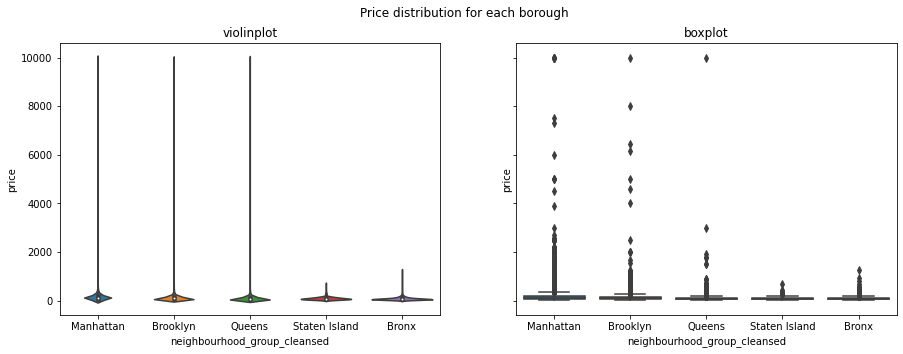

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Price distribution for each borough')

# violinplot
sns.violinplot(ax=axes[0], x='neighbourhood_group_cleansed', y='price',data=df)
axes[0].set_title('violinplot')
# Boxplot
sns.boxplot(ax=axes[1],  x='neighbourhood_group_cleansed', y='price',data=df)
axes[1].set_title('boxplot')

Text(0.5, 1.0, 'boxplot')

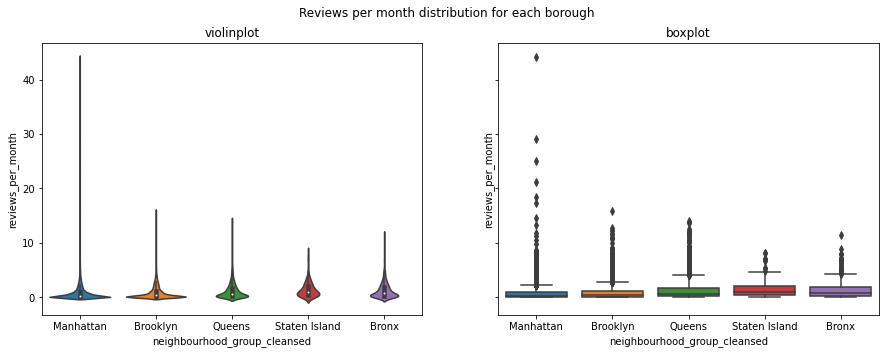

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Reviews per month distribution for each borough')

# violinplot
sns.violinplot(ax=axes[0], x='neighbourhood_group_cleansed', y='reviews_per_month',data=df)
axes[0].set_title('violinplot')
# Boxplot
sns.boxplot(ax=axes[1],  x='neighbourhood_group_cleansed', y='reviews_per_month',data=df)
axes[1].set_title('boxplot')

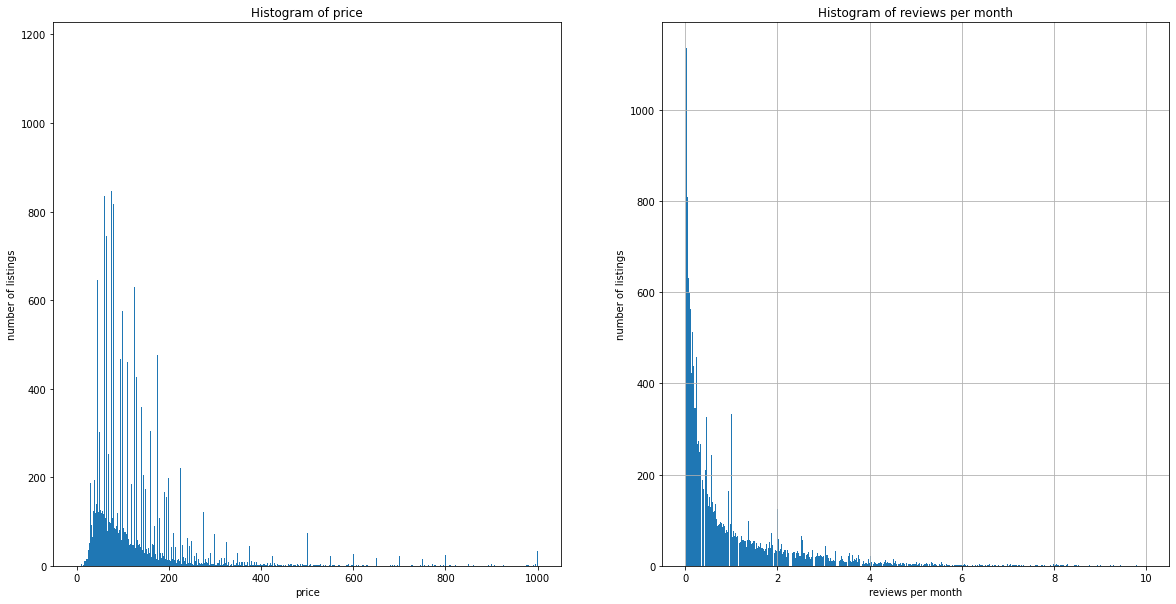

In [8]:
f, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].hist(df['price'],bins=1000,range=(0,1000))
ax[0].set_title('Histogram of price')
ax[0].set_xlabel('price')
ax[0].set_ylabel('number of listings')

df['reviews_per_month'].hist(bins=1000,range=(0,10))
ax[1].set_title('Histogram of reviews per month')
ax[1].set_xlabel('reviews per month')
ax[1].set_ylabel('number of listings') 
plt.show()

As we can see, most listings have **prices less than 400** and **reviews_per_month less than 6**

### Now we remove outliers 

In [9]:
df2 = df[df.price < 400]
preprocessed_df = df2[df2.reviews_per_month < 6]
preprocessed_df[['price','reviews_per_month','yield']].describe()

,price,reviews_per_month,yield
count,32771.000000,32771.000000,32771.000000
mean,116.580254,0.861460,3724.341015
std,71.005082,1.077132,5595.879392
min,9.000000,0.010000,11.520000
25%,65.000000,0.120000,460.800000
50%,99.000000,0.390000,1479.936000
75%,150.000000,1.190000,4608.000000
max,399.000000,5.990000,66831.744000


Text(0.5, 1.0, 'boxplot')

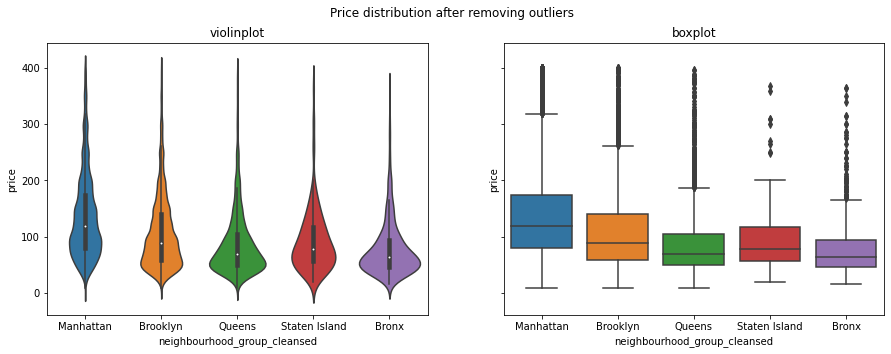

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Price distribution after removing outliers')

# violinplot
sns.violinplot(ax=axes[0], x='neighbourhood_group_cleansed', y='price',data=df2)
axes[0].set_title('violinplot')
# Boxplot
sns.boxplot(ax=axes[1],  x='neighbourhood_group_cleansed', y='price',data=df2)
axes[1].set_title('boxplot')

Text(0.5, 1.0, 'boxplot')

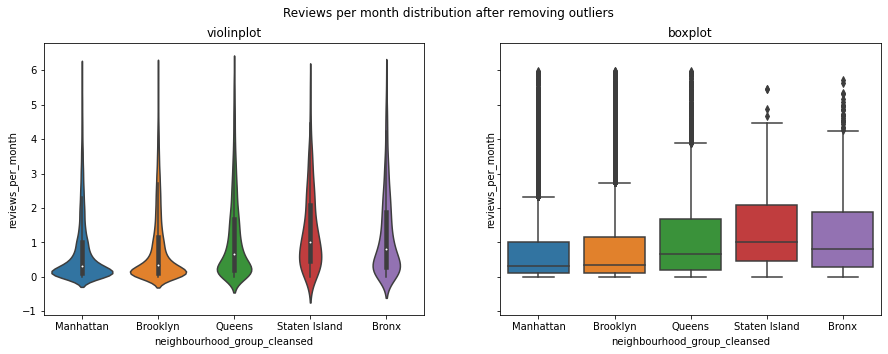

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Reviews per month distribution after removing outliers')

# violinplot
sns.violinplot(ax=axes[0], x='neighbourhood_group_cleansed', y='reviews_per_month',data=preprocessed_df)
axes[0].set_title('violinplot')
# Boxplot
sns.boxplot(ax=axes[1],  x='neighbourhood_group_cleansed', y='reviews_per_month',data=preprocessed_df)
axes[1].set_title('boxplot')

In [13]:
print("Percentage of the dataset after removing outliers: ", len(preprocessed_df.index)/len(df.index))

Percentage of the dataset after removing outliers:  0.9636828794918544


In [14]:
print("After preprocessing, the dataset has {} rows, {} columns.".format(*preprocessed_df.shape))
preprocessed_df.head()

After preprocessing, the dataset has 32771 rows, 30 columns.


,host_since,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,room_type,...,review_scores_rating,review_scores_accuracy,instant_bookable,reviews_per_month,name,amenities_count,bath_type,host_verifications_count,long term stays,yield
id,,,,,,,,,,,,,,,,,,,,,
2595,12.0,24,83,f,t,t,Manhattan,40.75362,-73.98377,Entire home/apt,...,94.0,9.0,f,0.37,Skylit Midtown Castle,31,0,9,1,2486.400
3831,12.0,1,94,f,t,t,Brooklyn,40.68514,-73.95976,Entire home/apt,...,89.0,8.0,f,4.82,"Whole flr w/private bdrm, bath & kitchen(pls r...",35,0,6,1,14066.688
5121,11.0,72,0,f,t,t,Brooklyn,40.68688,-73.95596,Private room,...,90.0,8.0,f,0.36,BlissArtsSpace!,4,0,8,1,829.440
5136,11.0,12,100,f,t,f,Brooklyn,40.66120,-73.99423,Entire home/apt,...,97.0,10.0,f,0.01,"Spacious Brooklyn Duplex, Patio + Garden",10,0,3,1,67.200
5178,11.0,12,100,f,t,f,Manhattan,40.76489,-73.98493,Private room,...,84.0,9.0,f,3.42,Large Furnished Room Near B'way,18,0,4,0,10374.912


# B. Data Analysis

### Here, we take a look at how the listings' locations impact their earning potential. 
### First, we visualize all the listings location using their co-ordinates. This helps us get an idea, at a high level, of how many properties are listed in a given neighbourhood/borough. In other words, listing density.

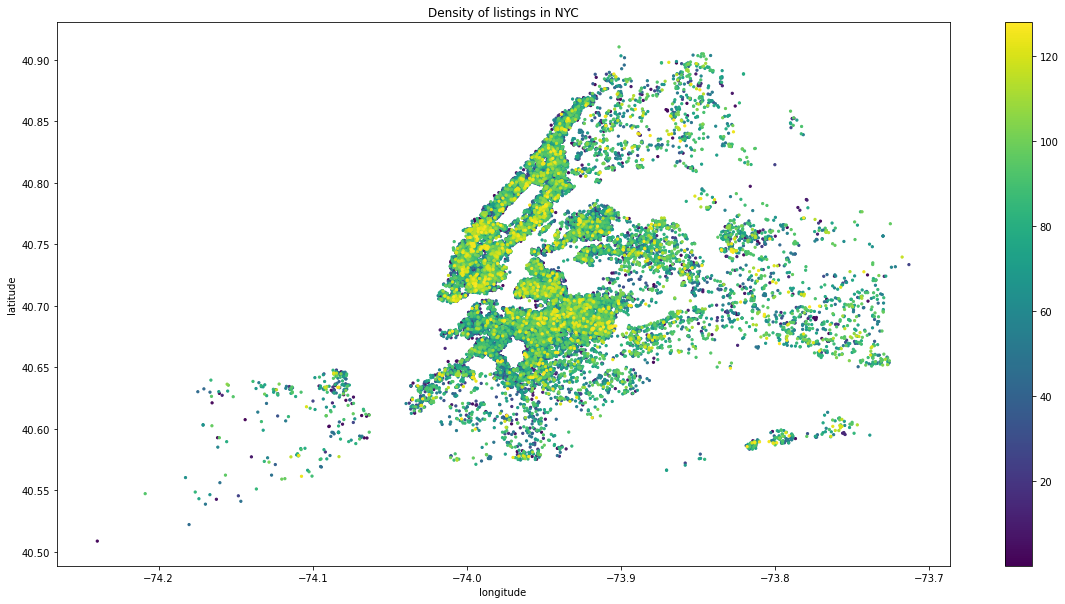

In [15]:
# plot the density of the hosts' location in NYC
lat = preprocessed_df['latitude']
lon = preprocessed_df['longitude']

xy = np.vstack([lat,lon])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
z=z[idx]

plt.figure(figsize=(20,10))
plt.scatter(lon, lat, c=z, s=5)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Density of listings in NYC")
plt.colorbar()
plt.show()

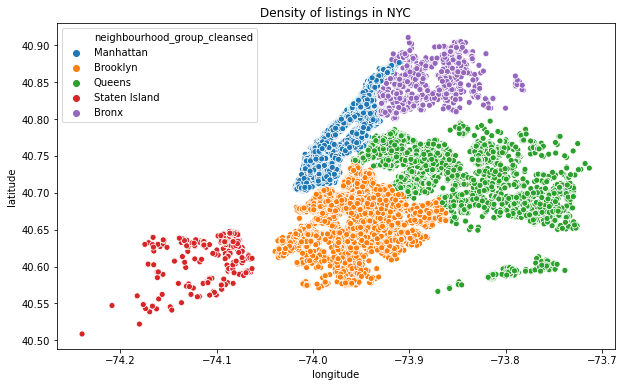

In [16]:
plt.figure(figsize=(10,6))
sns.scatterplot(preprocessed_df.longitude,preprocessed_df.latitude,hue=preprocessed_df.neighbourhood_group_cleansed)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Density of listings in NYC")
plt.show()

### Now we plot the number of listings per borough

In [17]:
preprocessed_df['neighbourhood_group_cleansed'].value_counts()

Brooklyn         13724
Manhattan        13682
Queens            4213
Bronx              895
Staten Island      257
Name: neighbourhood_group_cleansed, dtype: int64

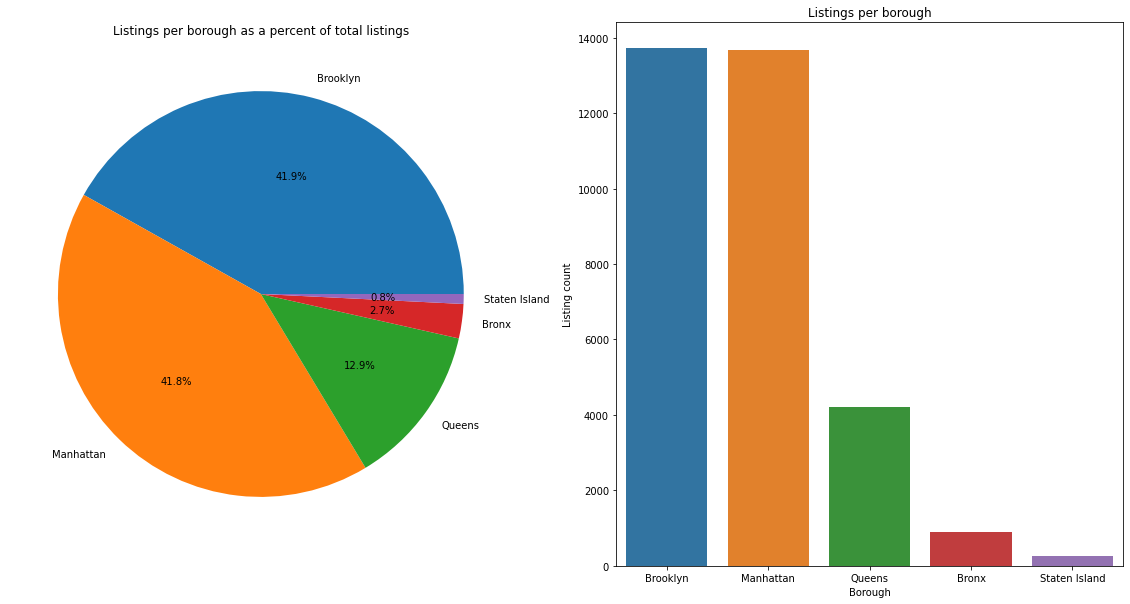

In [18]:
f,ax=plt.subplots(1,2,figsize=(20,10))
preprocessed_df['neighbourhood_group_cleansed'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0])
ax[0].set_title('Listings per borough as a percent of total listings')
ax[0].set_ylabel('')
sns.countplot('neighbourhood_group_cleansed',data=preprocessed_df,ax=ax[1],order=preprocessed_df['neighbourhood_group_cleansed'].value_counts().index)
ax[1].set_title('Listings per borough')
ax[1].set_xlabel('Borough')
ax[1].set_ylabel('Listing count')
plt.show()


As we can see, **Manhattan and Brooklyn have the most listings in the city** while **Staten Island has the least**. 
So we can surmise that **since there will be less competition in Staten Island, potential hosts may probably earn more money if they have properties there**. 

**But this is a very rudimentary analysis and therefore, we look for additional insights ahead.** 

### Now, we take a look at the average pricing as well as the overall pricing distribution for listings in each of the 5 boroughs

In [19]:
preprocessed_df['price'].describe()

count    32771.000000
mean       116.580254
std         71.005082
min          9.000000
25%         65.000000
50%         99.000000
75%        150.000000
max        399.000000
Name: price, dtype: float64

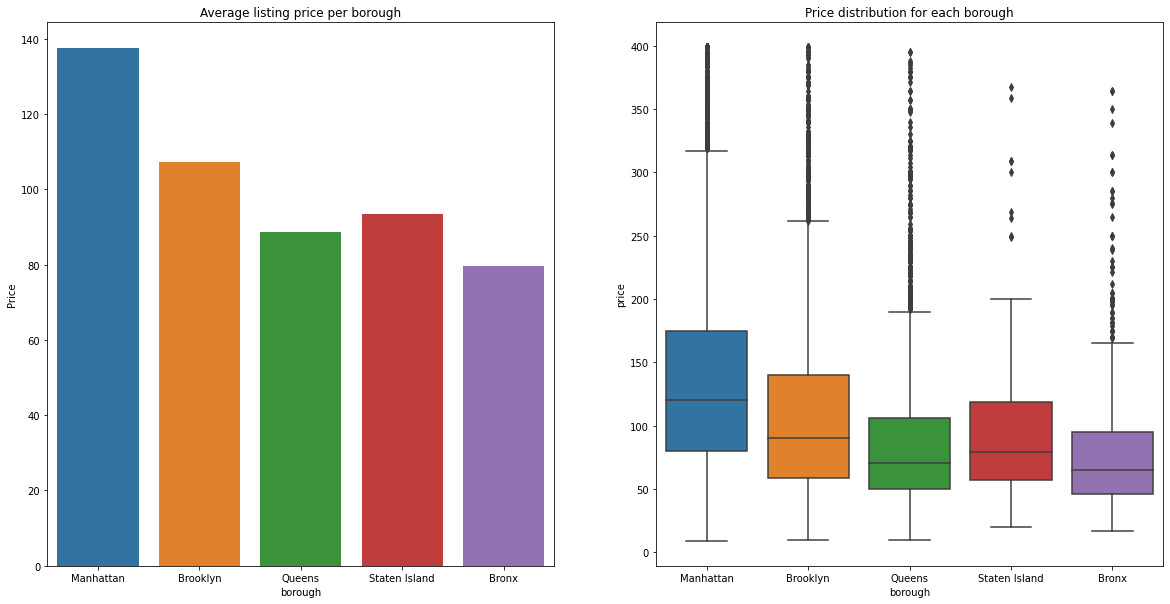

In [21]:
average_price = ([np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Manhattan"]["price"]),
      np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Brooklyn"]["price"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Queens"]["price"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Staten Island"]["price"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Bronx"]["price"])])

f,ax=plt.subplots(1,2,figsize=(20,10))
sns.barplot(x = ['Manhattan','Brooklyn','Queens','Staten Island','Bronx'], y = average_price, ax=ax[0])
ax[0].set_title("Average listing price per borough")
ax[0].set_ylabel("Price")
ax[0].set_xlabel("borough")
sns.boxplot(data=preprocessed_df, x='neighbourhood_group_cleansed', y='price',ax=ax[1])
ax[1].set_title('Price distribution for each borough')
ax[1].set_xlabel("borough")
plt.show()

In [22]:
average_price_table = pd.DataFrame([np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Manhattan"]["price"]),
      np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Brooklyn"]["price"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Queens"]["price"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Staten Island"]["price"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Bronx"]["price"])],
    index=['Manhattan','Brooklyn','Queens','Staten Island','Bronx'],
    columns=['Average Price for each borough'])
average_price_table

,Average Price for each borough
Manhattan,137.466063
Brooklyn,107.213435
Queens,88.554109
Staten Island,93.468054
Bronx,79.490402


We can see that **listings in Manhattan have the highest average price** while **those in the Bronx have the least**.

We also see that while the hosts charge the most for listings in Manhattan, **it also has the widest spread of prices**. 

This implies that **the hosts in Manhattan would face greater competition no matter what price range they choose since there are listings falling under nearly all price ranges in that borough.**

The opposite is the case with the Bronx: **the overall spread of the prices is most narrow for the Bronx**. 

This implies that **the hosts in Bronx would face lesser competition since there are fewer listings and there is a higher possibility of successfully finding an ideal price-point.**

### Now let's graph the average yield as well as the overall distribution of yield for listings in each of the 5 boroughs

In [23]:
preprocessed_df['yield'].describe()

count    32771.000000
mean      3724.341015
std       5595.879392
min         11.520000
25%        460.800000
50%       1479.936000
75%       4608.000000
max      66831.744000
Name: yield, dtype: float64

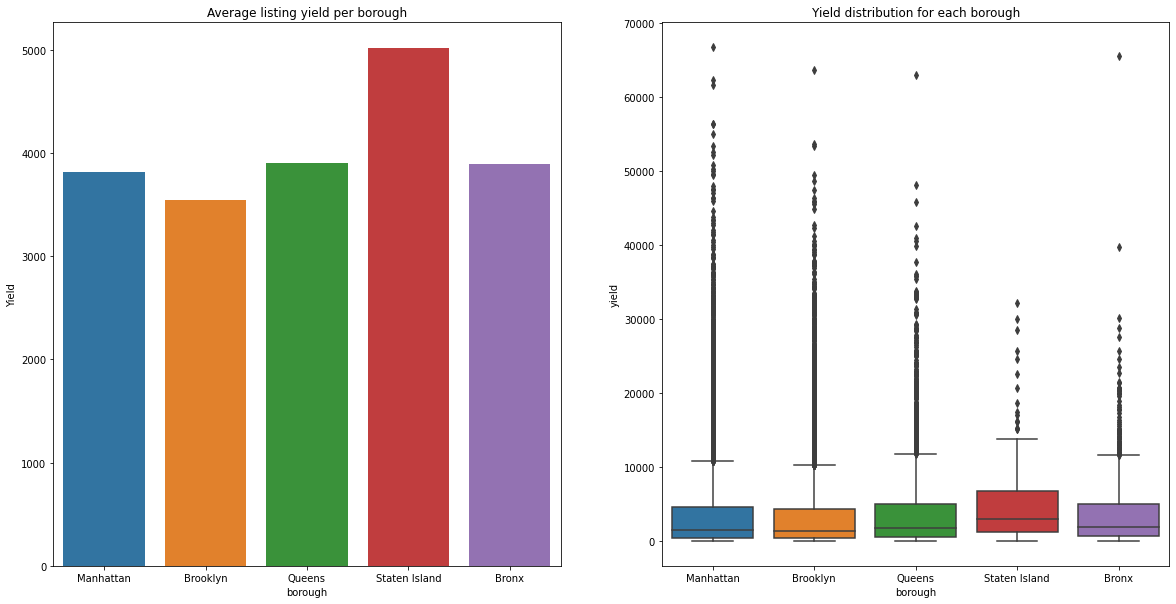

In [24]:
average_yield = [np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Manhattan"]["yield"]),
      np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Brooklyn"]["yield"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Queens"]["yield"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Staten Island"]["yield"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Bronx"]["yield"])]

f,ax=plt.subplots(1,2,figsize=(20,10))
sns.barplot(x = ['Manhattan','Brooklyn','Queens','Staten Island','Bronx'], y = average_yield, ax=ax[0])
ax[0].set_title("Average listing yield per borough")
ax[0].set_ylabel("Yield")
ax[0].set_xlabel("borough")
sns.boxplot(data=preprocessed_df, x='neighbourhood_group_cleansed', y='yield',ax=ax[1])
ax[1].set_title('Yield distribution for each borough')
ax[1].set_xlabel("borough")
plt.show()

In [25]:
average_yield_table =  pd.DataFrame([np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Manhattan"]["yield"]),
      np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Brooklyn"]["yield"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Queens"]["yield"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Staten Island"]["yield"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Bronx"]["yield"])],
    index=['Manhattan','Brooklyn','Queens','Staten Island','Bronx'],
    columns=['Average Yield for each borough'])
average_yield_table

,Average Yield for each borough
Manhattan,3816.587685
Brooklyn,3542.137664
Queens,3903.254399
Staten Island,5018.158797
Bronx,3894.359572


Despite having the 3rd highest average listing price, **Staten Island has the highest average listing yield**. This means that **the booking activity for listings in Staten Island is more than those in other boroughs**. A possible reason could be that Staten Island is generally quiter as it is somewhat removed from the rest of NYC but it is still near enough for guests to experience the city. 

Furthermore as stated previously, **Staten Island has the fewest listings and yet the highest average yield. This means that a given property in Staten Island gets booked relatively more often than those in other boroughs**. 

Therefore, **people with properties in Staten Island stand to earn pretty well**. 

The opposite is the case with Brooklyn which has the least average listing yield. **Brooklyn has the most listings in NYC as seen before and yet the least average yield**. 

It could be that the fact that **Brooklyn has the 2nd highest average listing price** might be discouraging to potential guests **leading to fewer bookings**, especially since Brooklyn is not as quiet as Staten Island and has fewer attractions than Manhattan which offers similar prices. 

Therefore, **people with properties in Brooklyn may find it difficult to generate substantial revenue**. 

### Moving right along, now we visualize the average number of reviews as well as the overall distribution of reviews for listings in each of the 5 boroughs.

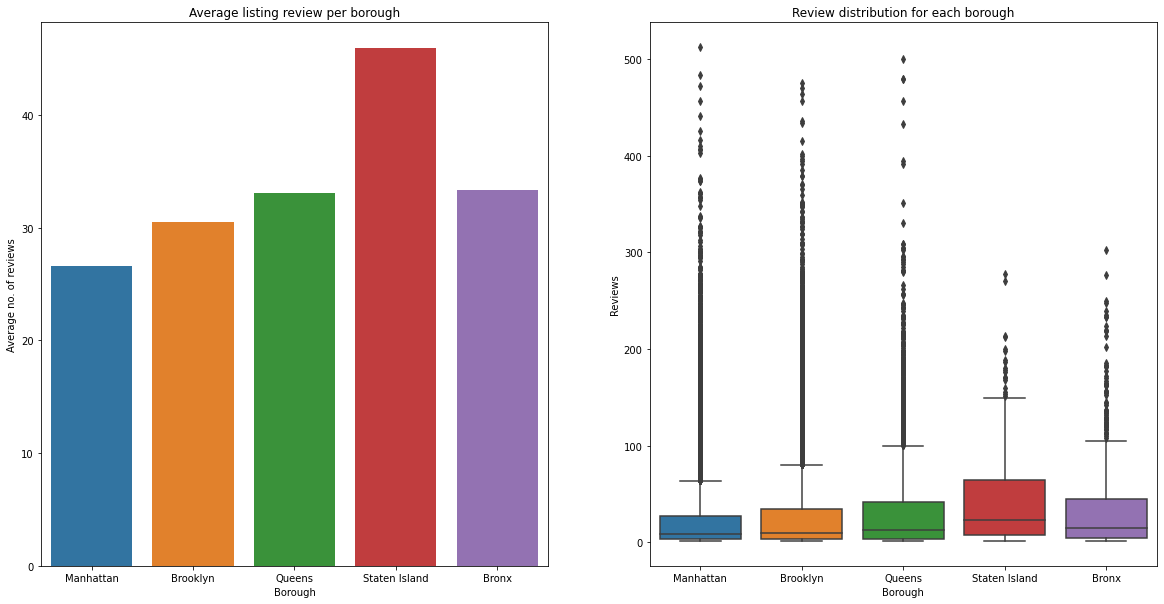

In [26]:
average_reviews = [np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Manhattan"]["number_of_reviews"]),
      np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Brooklyn"]["number_of_reviews"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Queens"]["number_of_reviews"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Staten Island"]["number_of_reviews"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Bronx"]["number_of_reviews"])]

f,ax=plt.subplots(1,2,figsize=(20,10))
sns.barplot(x = ['Manhattan','Brooklyn','Queens','Staten Island','Bronx'], y = average_reviews, ax=ax[0])
ax[0].set_title("Average listing review per borough")
ax[0].set_ylabel("Average no. of reviews")
ax[0].set_xlabel("Borough")
sns.boxplot(data=preprocessed_df, x='neighbourhood_group_cleansed', y='number_of_reviews',ax=ax[1])
ax[1].set_title('Review distribution for each borough')
ax[1].set_xlabel("Borough")
ax[1].set_ylabel("Reviews")
plt.show()

In [27]:
average_reviews_table =  pd.DataFrame([np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Manhattan"]["number_of_reviews"]),
      np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Brooklyn"]["number_of_reviews"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Queens"]["number_of_reviews"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Staten Island"]["number_of_reviews"]),
     np.mean(preprocessed_df[preprocessed_df.neighbourhood_group_cleansed=="Bronx"]["number_of_reviews"])],
    index=['Manhattan','Brooklyn','Queens','Staten Island','Bronx'],
    columns=['Average numbers of Reviews for each borough'])
average_reviews_table

,Average numbers of Reviews for each borough
Manhattan,26.616577
Brooklyn,30.478651
Queens,33.028009
Staten Island,45.910506
Bronx,33.334078


**Guests can post reviews for a listing if and only if they have booked said listing**
This means that the number of reviews for a given listing is equal to the minimum number of bookings that said listing has had in its lifetime. For example **if a property has 10 reviews, then that property has been booked at least 10 times**. 

Here we see that the **average number of reviews is highest for Staten Island** which confirms our statement above that **on average, Staten Island sees the most bookings**. 

**Brooklyn on the other hand has the 4th lowest average number of reviews** which again confirms our statement above that **on average, Brooklyn has far fewer bookings in comparison** 

**Manhattan has the least average number of reviews** but due to its high price, its average yield is higher than Brooklyn. 

As yield is obviously dependent on the number of times a property is booked, it is easy to see why listings in Staten Island generate high revenues while those in Brooklyn struggle. 

## Here, we take a look at how the types of properties impact their earning potential.
### We first visualize the count of each property type for all 5 boroughs.

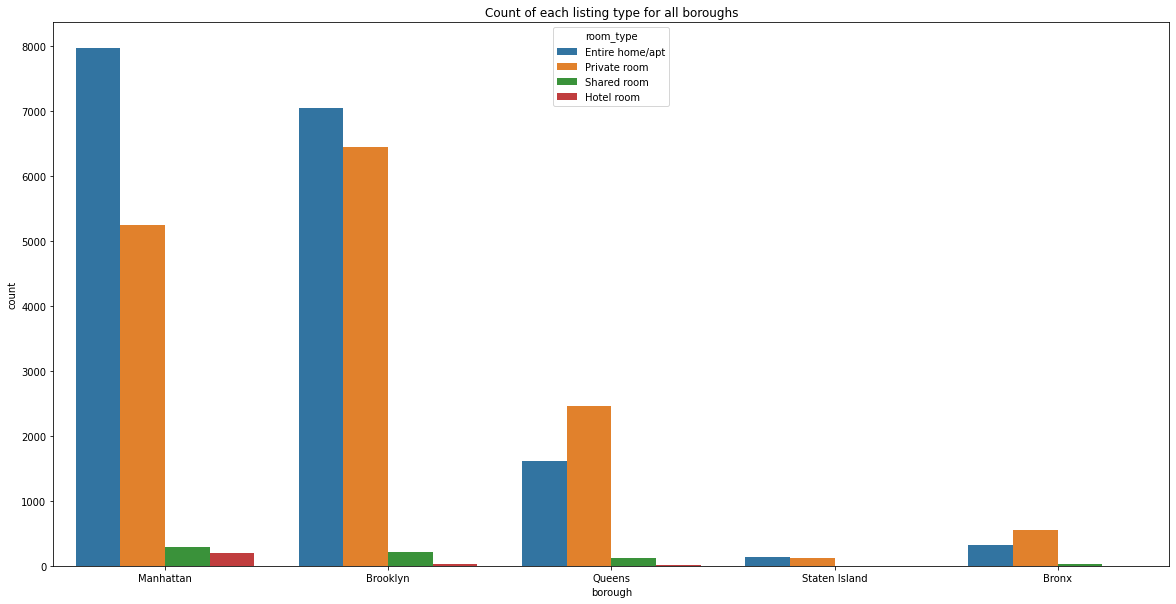

In [28]:
plt.figure(figsize=(20,10))
sns.countplot(x = 'neighbourhood_group_cleansed', hue = "room_type", data = preprocessed_df)
plt.xlabel("borough")
plt.title("Count of each listing type for all boroughs")
plt.show()

In [29]:
preprocessed_df.groupby(['room_type', 'neighbourhood_group_cleansed']).size()

room_type        neighbourhood_group_cleansed
Entire home/apt  Bronx                            315
                 Brooklyn                        7042
                 Manhattan                       7964
                 Queens                          1619
                 Staten Island                    140
Hotel room       Brooklyn                          25
                 Manhattan                        191
                 Queens                            12
Private room     Bronx                            550
                 Brooklyn                        6442
                 Manhattan                       5240
                 Queens                          2463
                 Staten Island                    114
Shared room      Bronx                             30
                 Brooklyn                         215
                 Manhattan                        287
                 Queens                           119
                 Staten Island      

We can make out that **Manhattan has all 4 property types**. This means that the hosts in Manhattan will have to face **greater competition regardless of their property's type**. 

This combined with the fact that we observed earlier, that Manhattan also has the widest price range means that **the potential for hosts to earn significant revenue in Manhattan is relatively lower due to sheer saturation and increased competition**. 

The same can be said for Brooklyn as well since **it also has all 4 property types and the price distribution for listings in Brooklyn is similar to that of Manhattan**. 

**Queens, Bronx and Staten Island seem to be much more lucrative**. 
Bronx and Staten Island do not have all 4 property types and just that fact alone means that bthere will be less competition. In fact, **there are no "Hotel rooms" in both Staten Island and the Bronx** and therefore, **for people who own such a property in either of these boroughs, there will be no existing competition**. 

Queens also has all 4 property types but its lower average listing price makes it attractive to potential guests and could thus lead to more bookings which in turn will lead to substantial revenue. In this case, **there are hotel rooms but very few and thus low competition**.


### Now let's graph the average price as well as the overall distribution of prices for all property types in each of the 5 boroughs

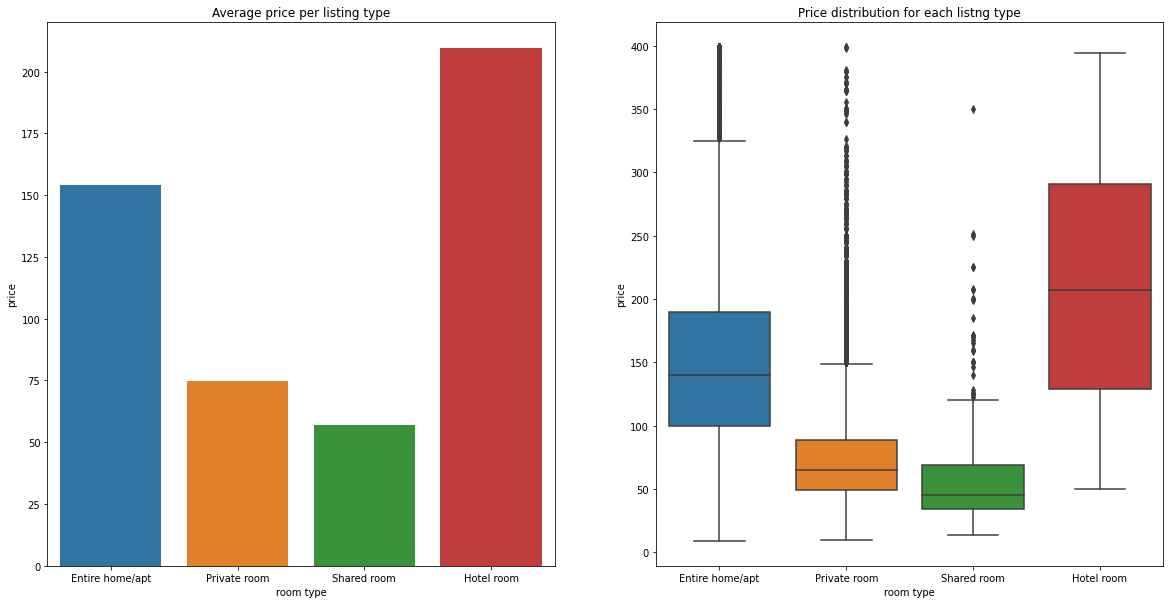

In [30]:
average_price_room = [np.mean(preprocessed_df[preprocessed_df.room_type=="Entire home/apt"]["price"]),
      np.mean(preprocessed_df[preprocessed_df.room_type=="Private room"]["price"]),
     np.mean(preprocessed_df[preprocessed_df.room_type=="Shared room"]["price"]),
     np.mean(preprocessed_df[preprocessed_df.room_type=="Hotel room"]["price"])]

f,ax=plt.subplots(1,2,figsize=(20,10))
sns.barplot(x = ['Entire home/apt','Private room','Shared room','Hotel room'], y = average_price_room, ax=ax[0])
ax[0].set_title("Average price per listing type")
ax[0].set_ylabel("price")
ax[0].set_xlabel("room type")
sns.boxplot(data=preprocessed_df, x='room_type', y='price',ax=ax[1])
ax[1].set_title('Price distribution for each listng type')
ax[1].set_xlabel("room type")
plt.show()

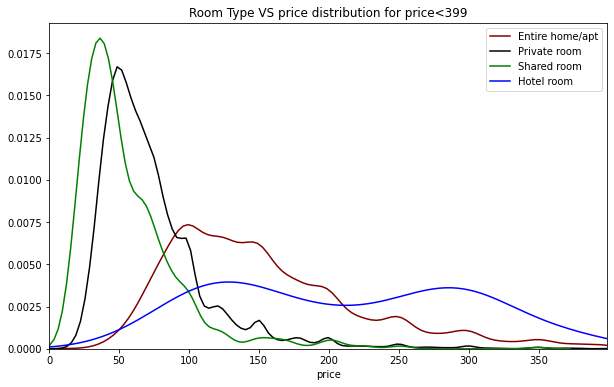

In [32]:
plt.figure(figsize=(10,6))
sns.distplot(preprocessed_df[preprocessed_df.room_type=='Entire home/apt'].price,color='maroon',hist=False,label='Entire home/apt')
sns.distplot(preprocessed_df[preprocessed_df.room_type=='Private room'].price,color='black',hist=False,label='Private room')
sns.distplot(preprocessed_df[preprocessed_df.room_type=='Shared room'].price,color='green',hist=False,label='Shared room')
sns.distplot(preprocessed_df[preprocessed_df.room_type=='Hotel room'].price,color='blue',hist=False,label='Hotel room')
plt.title('Room Type VS price distribution for price<399')
plt.xlim(0,399)
plt.show()

In [33]:
average_price_roomtype_table =  pd.DataFrame([np.mean(preprocessed_df[preprocessed_df.room_type=="Entire home/apt"]["price"]),
      np.mean(preprocessed_df[preprocessed_df.room_type=="Private room"]["price"]),
     np.mean(preprocessed_df[preprocessed_df.room_type=="Shared room"]["price"]),
     np.mean(preprocessed_df[preprocessed_df.room_type=="Hotel room"]["price"])],
    index=['Entire home/apt','Private room','Shared room','Hotel room'],
    columns=['Average price of each room type'])
average_price_roomtype_table

,Average price of each room type
Entire home/apt,154.014268
Private room,74.610706
Shared room,56.896040
Hotel room,209.508158


We can see that **a hotel room has the highest average price while that of the shared room is the least**. 

In fact, **the price for hotel rooms is significantly higher** than all other property types.

## Now let's graph the average yield, the overall distribution of yields for all property types in each of the 5 boroughs as well as average no. of reviews per property type.

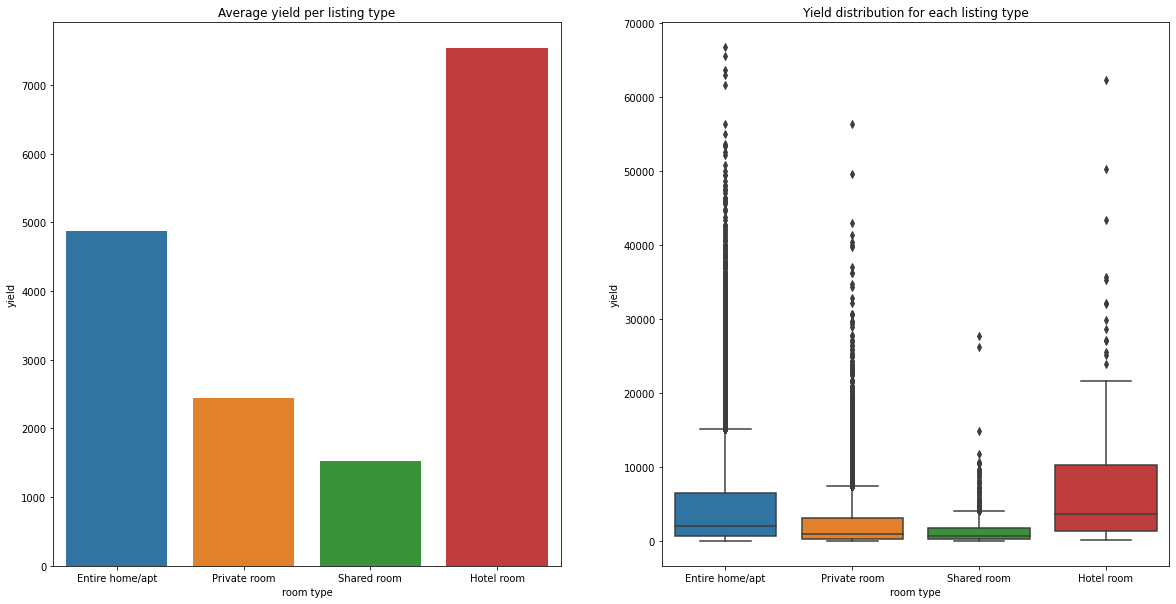

In [34]:
average_yield_room = [np.mean(preprocessed_df[preprocessed_df.room_type=="Entire home/apt"]["yield"]),
      np.mean(preprocessed_df[preprocessed_df.room_type=="Private room"]["yield"]),
     np.mean(preprocessed_df[preprocessed_df.room_type=="Shared room"]["yield"]),
     np.mean(preprocessed_df[preprocessed_df.room_type=="Hotel room"]["yield"])]

f,ax=plt.subplots(1,2,figsize=(20,10))
sns.barplot(x = ['Entire home/apt','Private room','Shared room','Hotel room'], y = average_yield_room, ax=ax[0])
ax[0].set_title("Average yield per listing type")
ax[0].set_ylabel("yield")
ax[0].set_xlabel("room type")
sns.boxplot(data=preprocessed_df, x='room_type', y='yield',ax=ax[1])
ax[1].set_title('Yield distribution for each listing type')
ax[1].set_xlabel("room type")
plt.show()

In [35]:
average_yield_roomtype_table =  pd.DataFrame([np.mean(preprocessed_df[preprocessed_df.room_type=="Entire home/apt"]["yield"]),
      np.mean(preprocessed_df[preprocessed_df.room_type=="Private room"]["yield"]),
     np.mean(preprocessed_df[preprocessed_df.room_type=="Shared room"]["yield"]),
     np.mean(preprocessed_df[preprocessed_df.room_type=="Hotel room"]["yield"])],
    index=['Entire home/apt','Private room','Shared room','Hotel room'],
    columns=['Average yield of each room type'])
average_yield_roomtype_table

,Average yield of each room type
Entire home/apt,4870.093951
Private room,2441.397807
Shared room,1522.713101
Hotel room,7537.983512


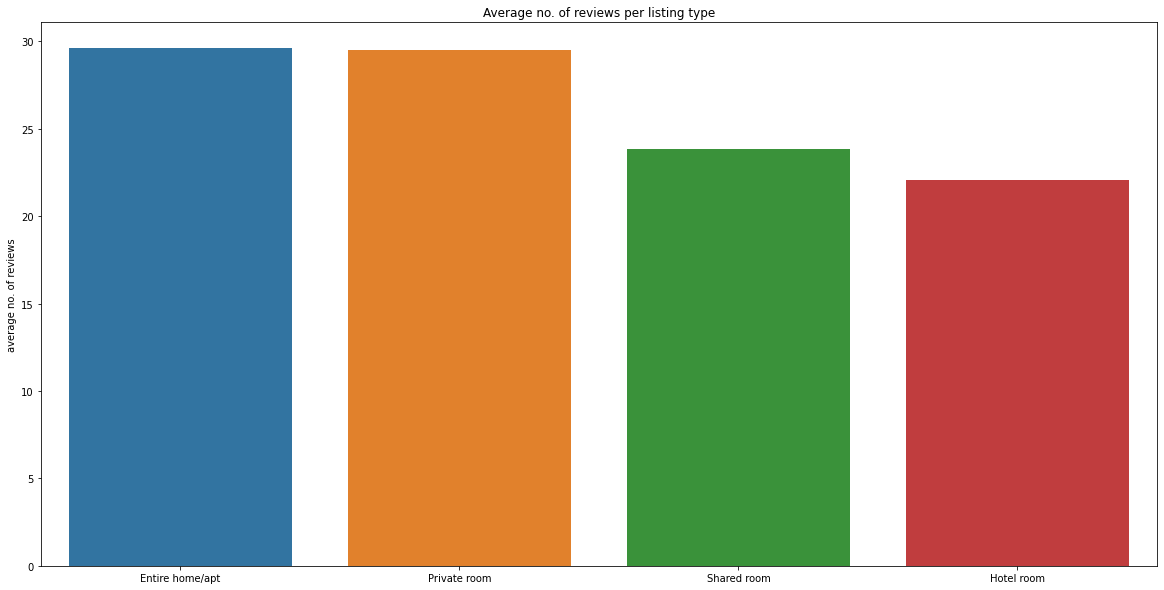

In [36]:
average_review_room = [np.mean(preprocessed_df[preprocessed_df.room_type=="Entire home/apt"]["number_of_reviews"]),
      np.mean(preprocessed_df[preprocessed_df.room_type=="Private room"]["number_of_reviews"]),
     np.mean(preprocessed_df[preprocessed_df.room_type=="Shared room"]["number_of_reviews"]),
     np.mean(preprocessed_df[preprocessed_df.room_type=="Hotel room"]["number_of_reviews"])]

sns.barplot(x = ['Entire home/apt','Private room','Shared room','Hotel room'], y = average_review_room, ax=plt.subplots(figsize=(20,10))[1])
plt.ylabel("average no. of reviews")
plt.title("Average no. of reviews per listing type")
plt.show()

In [37]:
average_reviews_roomtype_table =  pd.DataFrame([np.mean(preprocessed_df[preprocessed_df.room_type=="Entire home/apt"]["number_of_reviews"]),
      np.mean(preprocessed_df[preprocessed_df.room_type=="Private room"]["number_of_reviews"]),
     np.mean(preprocessed_df[preprocessed_df.room_type=="Shared room"]["number_of_reviews"]),
     np.mean(preprocessed_df[preprocessed_df.room_type=="Hotel room"]["number_of_reviews"])],
    index=['Entire home/apt','Private room','Shared room','Hotel room'],
    columns=['Average number_of_reviews of each room type'])
average_reviews_roomtype_table

,Average number_of_reviews of each room type
Entire home/apt,29.611534
Private room,29.498075
Shared room,23.854740
Hotel room,22.078947


Again, **Guests can post reviews for a listing if and only if they have booked that listing**. 
Thus, number of reviews for a property reflect the minimum number of bookings for that property. 

**Clearly, hotel rooms bring in the highest revenue on average**. However, we also see that **hotel rooms have the least number of reviews and thus, the least minimum number of bookings**. 

We have seen that **hotel rooms' average price is the highest and is considerably more than the other 3 types' prices**. This is why their yield on average is the highest despite relatively low bookings.

Having said that, not everyone is in a position to own a hotel and therefore, **a private room or the entire home/apt would make more sense for most hosts**. 

**a private room and an entire home are booked more often**

**An entire home has the 2nd highest average price and the highest minimum number of bookings**. Therefore, it's average **yield**, as we can see, **is the 2nd highest**. 

**A private room has the 3rd highest average price and the 2nd highest minimum number of bookings**. Therefore, it's average **yield**, as we can see, **is the 3rd highest**. 

A shared room is not only **booked less often** but also **has the least average price** and that is why, **it has the lowest yield**.

Thus, **a hotel room is most lucrative but for those who do not own a hotel room, a private room or an entire home will be ideal**. 

### Here, we take a look at how the type of the host him/herself (superhost or not) impacts their properties' earning potential.
**First, we visualize all the listings (with and without superhosts) using their co-ordinates**. 

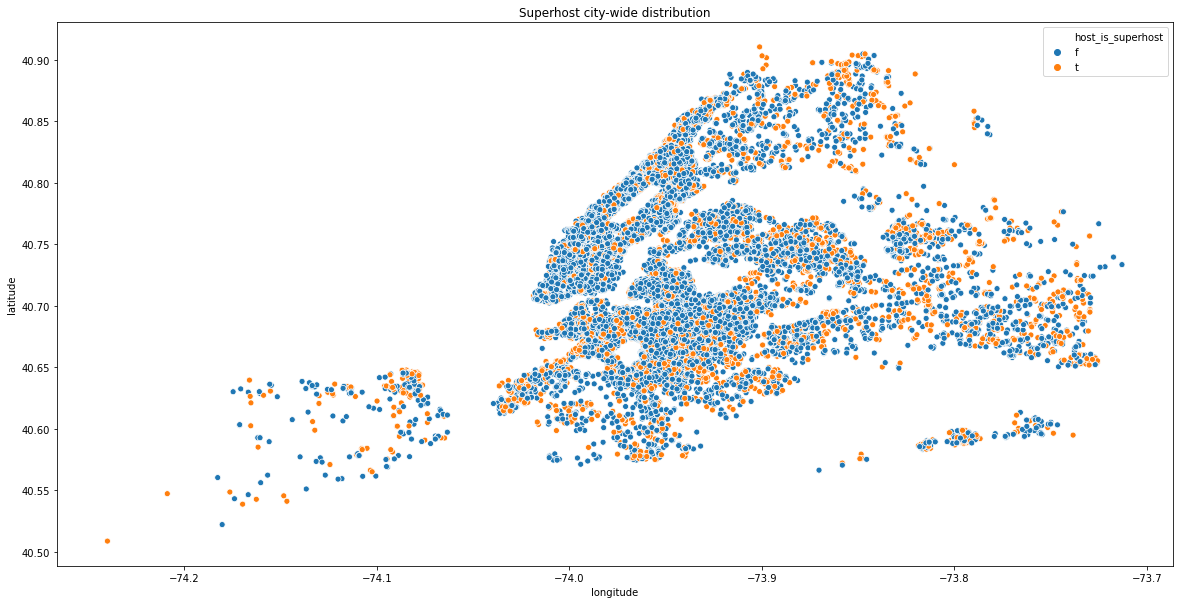

In [38]:
plt.figure(figsize=(20,10))
sns.scatterplot(preprocessed_df.longitude,preprocessed_df.latitude,hue=preprocessed_df.host_is_superhost)
plt.title('Superhost city-wide distribution')
plt.show()

In [39]:
preprocessed_df.groupby(['host_is_superhost', 'neighbourhood_group_cleansed']).size()

host_is_superhost  neighbourhood_group_cleansed
f                  Bronx                             584
                   Brooklyn                        10170
                   Manhattan                       10936
                   Queens                           2875
                   Staten Island                     148
t                  Bronx                             311
                   Brooklyn                         3554
                   Manhattan                        2746
                   Queens                           1338
                   Staten Island                     109
dtype: int64

In [40]:
preprocessed_df['host_is_superhost'].value_counts() # "t" means that the host is a superhost. 

f    24713
t     8058
Name: host_is_superhost, dtype: int64

In [41]:
print("There are only", round(preprocessed_df['host_is_superhost'][preprocessed_df['host_is_superhost']=='t'].count()
                              /preprocessed_df['host_is_superhost'][preprocessed_df['host_is_superhost']=='f'].count(),2), "of hosts want to stay with the guests")

There are only 0.33 of hosts want to stay with the guests


**We see that around a third of all the hosts are superhosts** and they are spread out all over NYC, thus bearing no relationship with location. 

### Now lets visualize the average price as well as the distribution of prices for both ordinary and superhosts 

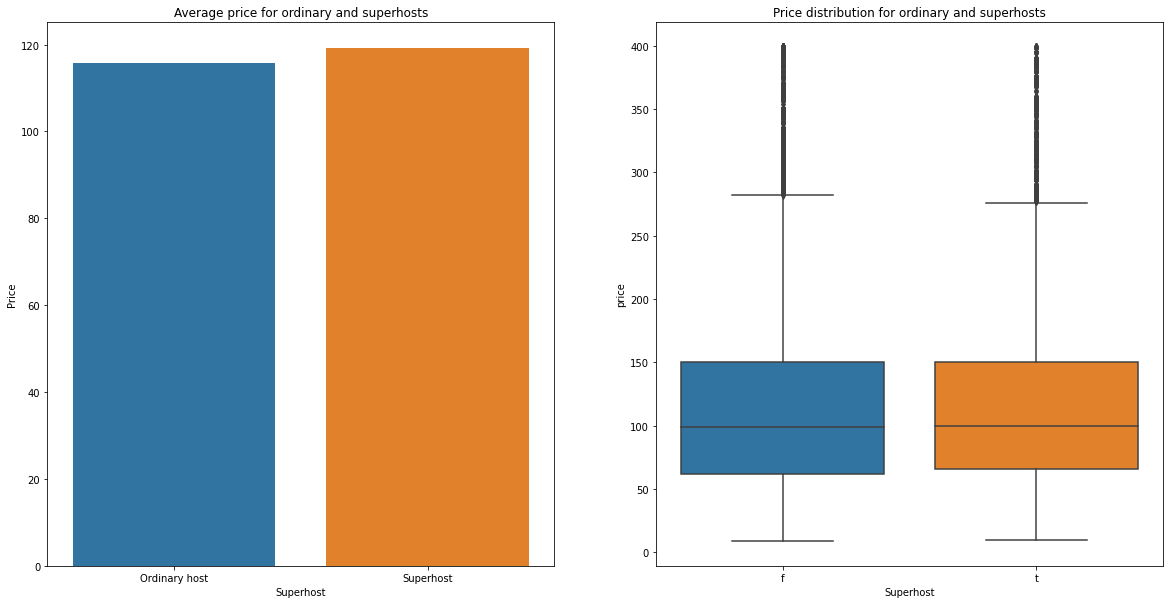

In [42]:
average_price = [np.mean(preprocessed_df[preprocessed_df.host_is_superhost=="f"]["price"]),
      np.mean(preprocessed_df[preprocessed_df.host_is_superhost=="t"]["price"])]

f,ax=plt.subplots(1,2,figsize=(20,10))
sns.barplot(x = ['Ordinary host','Superhost'], y = average_price, ax=ax[0])
ax[0].set_title("Average price for ordinary and superhosts")
ax[0].set_ylabel("Price")
ax[0].set_xlabel("Superhost")
sns.boxplot(data=preprocessed_df, x='host_is_superhost', y='price',ax=ax[1])
ax[1].set_title('Price distribution for ordinary and superhosts')
ax[1].set_xlabel("Superhost")
plt.show()

In [43]:
average_price_superhost_table =  pd.DataFrame([np.mean(preprocessed_df[preprocessed_df.host_is_superhost=="f"]["price"]),
      np.mean(preprocessed_df[preprocessed_df.host_is_superhost=="t"]["price"])],
    index=['Ordinary Host','Super Host'],
    columns=['Average price of host type'])
average_price_superhost_table

,Average price of host type
Ordinary Host,115.732223
Super Host,119.181073


As can be seen, **superhosts charge a higher price on average but the difference is not much**. In fact, even the distribution is nearly identical. 

### So, lets visualize the average yield as well as the distribution of yield for both ordinary and superhosts

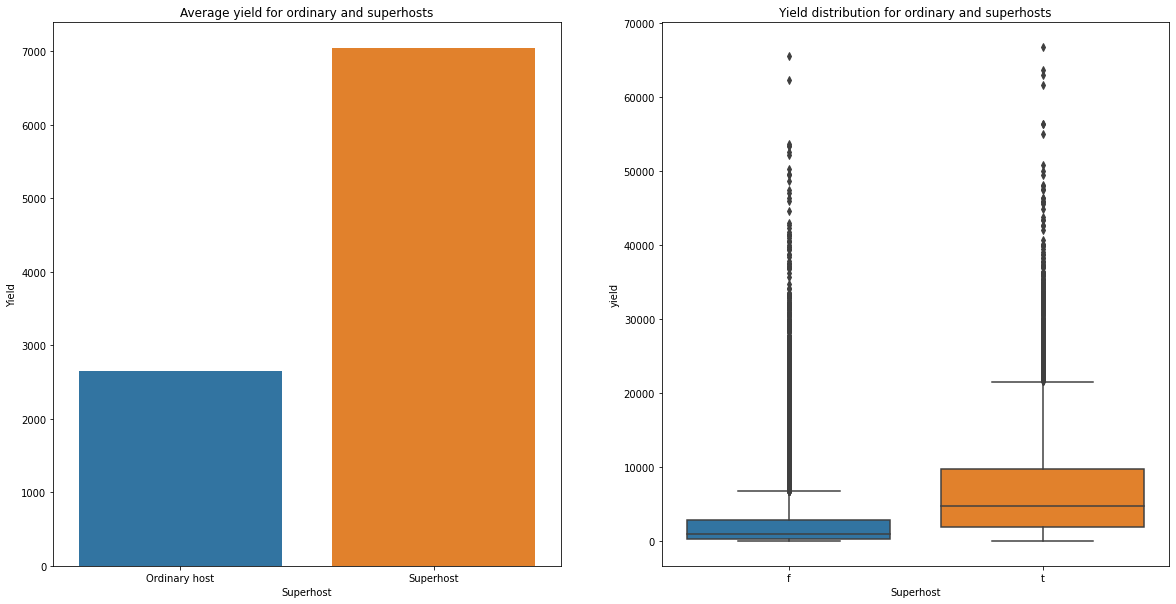

In [44]:
average_yield = [np.mean(preprocessed_df[preprocessed_df.host_is_superhost=="f"]["yield"]),
      np.mean(preprocessed_df[preprocessed_df.host_is_superhost=="t"]["yield"])]

f,ax=plt.subplots(1,2,figsize=(20,10))
sns.barplot(x = ['Ordinary host','Superhost'], y = average_yield, ax=ax[0])
ax[0].set_title("Average yield for ordinary and superhosts")
ax[0].set_ylabel("Yield")
ax[0].set_xlabel("Superhost")
sns.boxplot(data=preprocessed_df, x='host_is_superhost', y='yield',ax=ax[1])
ax[1].set_title('Yield distribution for ordinary and superhosts')
ax[1].set_xlabel("Superhost")
plt.show()

In [45]:
average_yield_superhost_table =  pd.DataFrame([np.mean(preprocessed_df[preprocessed_df.host_is_superhost=="f"]["yield"]),
      np.mean(preprocessed_df[preprocessed_df.host_is_superhost=="t"]["yield"])],
    index=['Ordinary Host','Super Host'],
    columns=['Average yield of host type'])
average_yield_superhost_table

,Average yield of host type
Ordinary Host,2643.445546
Super Host,7039.328572


There is **a big difference** between the average yield earned by superhosts and that by ordinary hosts. 

**Considering that the price difference was very small, it must mean that people book superhosts' properties more**. 

Let's confirm this by **graphing average number of reviews for listings with ordinary and superhosts**.

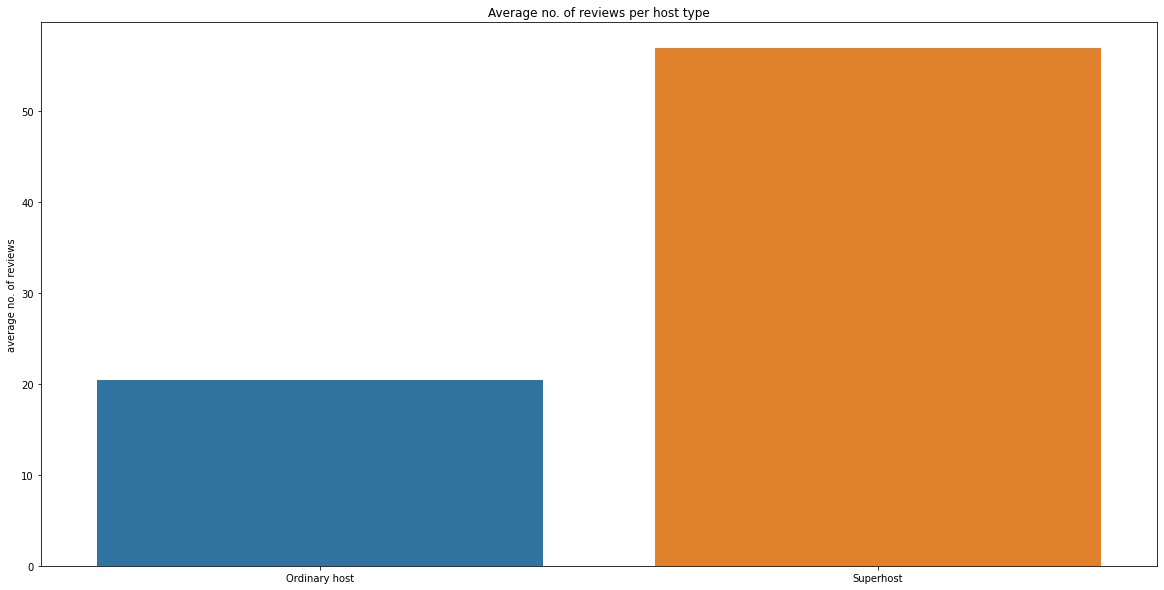

In [46]:
average_review_host = [np.mean(preprocessed_df[preprocessed_df.host_is_superhost=="f"]["number_of_reviews"]),
      np.mean(preprocessed_df[preprocessed_df.host_is_superhost=="t"]["number_of_reviews"])]

sns.barplot(x = ['Ordinary host','Superhost'], y = average_review_host, ax=plt.subplots(figsize=(20,10))[1])
plt.ylabel("average no. of reviews")
plt.title("Average no. of reviews per host type")
plt.show()

Again, **Guests can post reviews for a listing if and only if they have booked said listing**. 

Therefore, as we can see, **listings with superhosts have an average number of reviews higher than 50** while those **with ordinary hosts have an average number of reviews of around 20**. 

In other words, **listings with superhosts receive more than twice as many reviews on average** and therefore, are **booked at least twice as many times** as ordinary hosts. 

Thus, this confirms our previous statement that **people book superhosts' properties more, thereby increasing the yield**. 

Hence, **a host can increase his/her revenue by becoming a superhost**. 

## Now, lets analyze how a property's annual availability (how many days in a year is a property available for booking) affects its revenue earning potential. 

Obviously, **greater the number of days for which a property is available to book, the greater the chances for it to be booked and thus generate revenue.**

But the dataset shows us something beyond the obvious and much more relevant to the current scenario. **We can see below that we have listings that are available for 0 days. That is, they are unavailable throughtout the year**. 

In [47]:
preprocessed_df['availability_365'].describe()

count    32771.000000
mean       120.845076
std        141.499960
min          0.000000
25%          0.000000
50%         58.000000
75%        251.000000
max        365.000000
Name: availability_365, dtype: float64

In [48]:
preprocessed_df['availability_365'].value_counts().head(10)

0      14123
365     2029
364      861
89       620
179      517
90       512
180      459
363      369
88       285
343      281
Name: availability_365, dtype: int64

**Now let's see how many listings are available for at least 1 day.**

In [49]:
available_listings = preprocessed_df[preprocessed_df['availability_365']>0]
len(list(available_listings['availability_365']))

18648

**Now let's see how many listings are unavailable, that is, 0 days.**

In [50]:
unavailable_listings = preprocessed_df[preprocessed_df['availability_365']==0]
len(list(unavailable_listings['availability_365']))

14123

**Thus, we see that more than 40% of all the listings in NYC are unavailable**. 

Following are the plots for both available and unavailable listings.

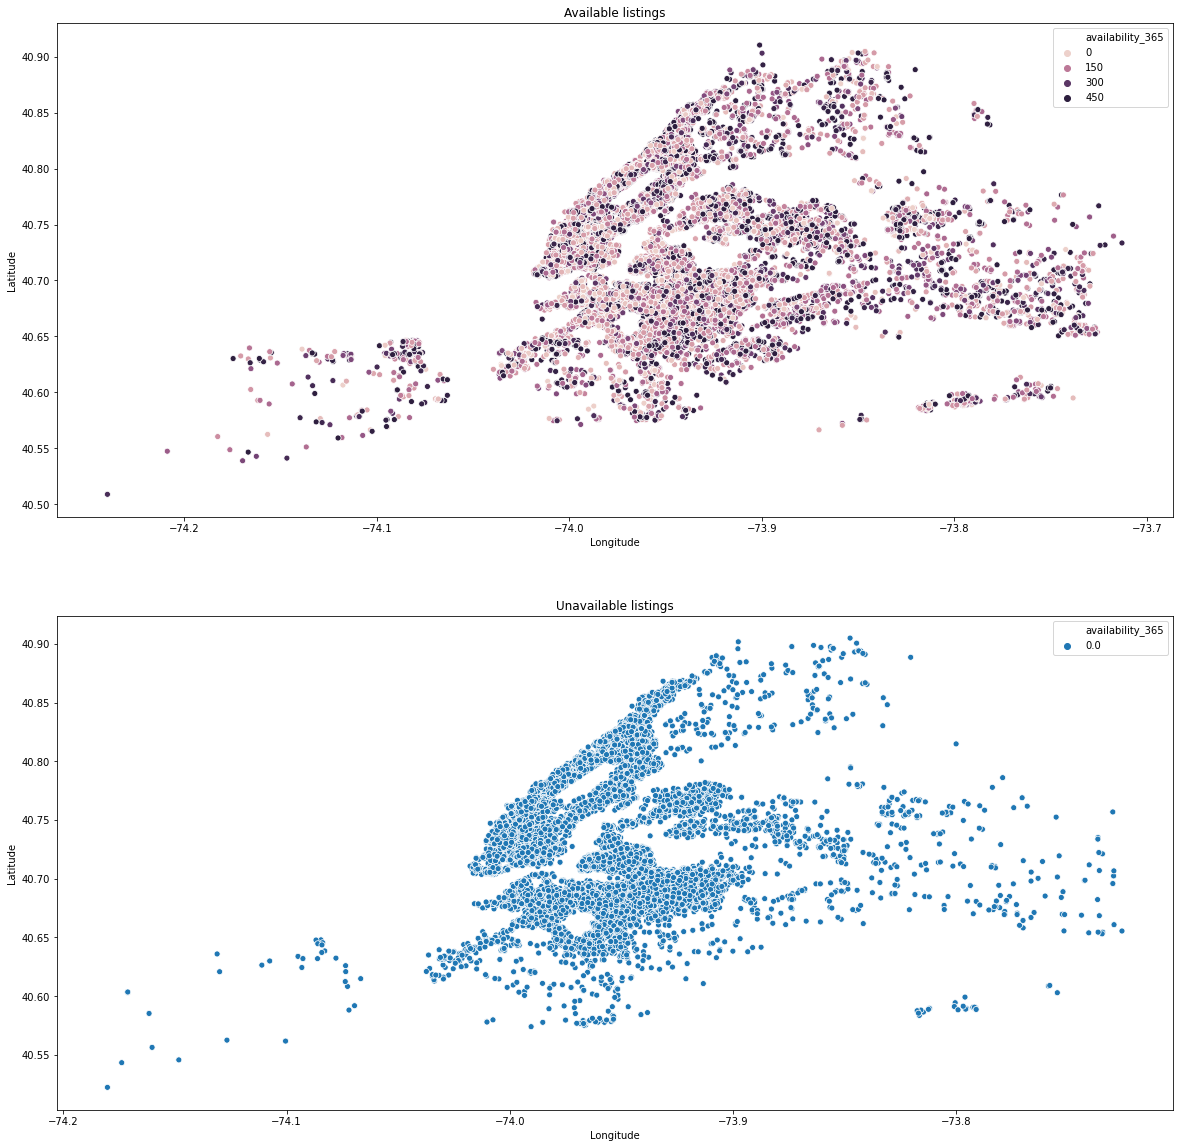

In [51]:
f,ax=plt.subplots(2,1,figsize=(20,20))
sns.scatterplot(preprocessed_df.longitude,preprocessed_df.latitude,hue=available_listings.availability_365,ax=ax[0])
ax[0].set_title("Available listings")
ax[0].set_ylabel("Latitude")
ax[0].set_xlabel("Longitude")
sns.scatterplot(preprocessed_df.longitude,preprocessed_df.latitude,hue=unavailable_listings.availability_365,ax=ax[1])
ax[1].set_title('Unavailable listings')
ax[1].set_ylabel("Latitude")
ax[1].set_xlabel("Longitude")
plt.show()

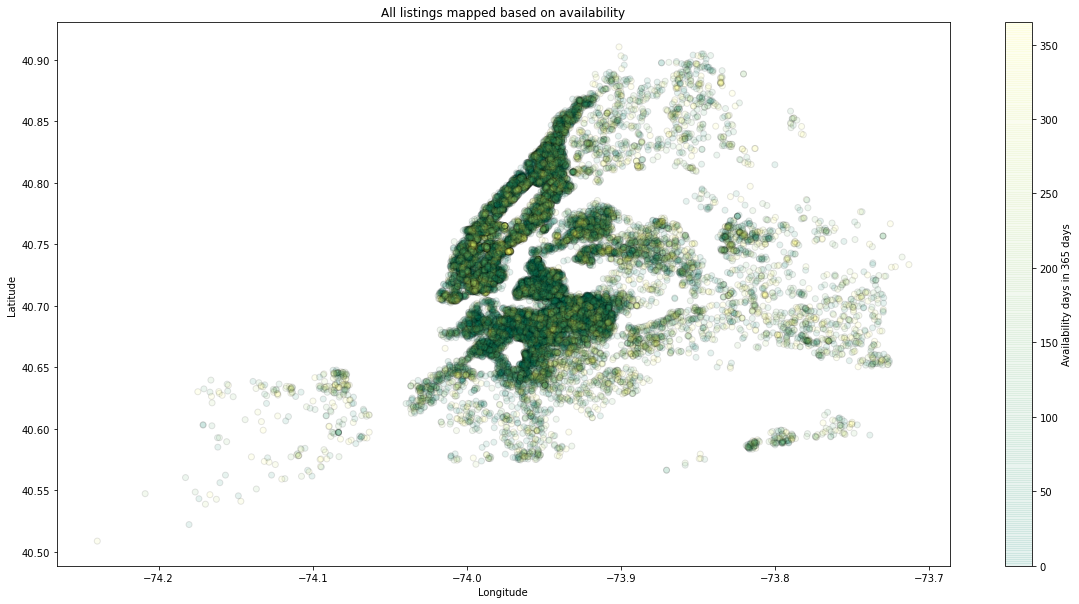

In [58]:
plt.figure(figsize=(20,10))
plt.scatter(preprocessed_df.longitude, preprocessed_df.latitude, c=preprocessed_df.availability_365, cmap='summer', edgecolor='black', linewidth=1, alpha=0.1)
cbar = plt.colorbar()
cbar.set_label('Availability days in 365 days')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("All listings mapped based on availability")
plt.show()

Upon closer examination of the second map, we can see just how many properties on AirBnB are not available for booking. 

**A possible reason could be that during the Coronavirus pandemic, hosts are unwilling to accept guests**. 

At the moment, **there are less than 60% of the total listings active**. However, this **can be a good thing for a potential host**. 

*Assuming that there is a healthy demand from the guests' side*, the hosts can **potentially get many more bookings and thus earn more revenue** than he/she would have otherwise **as there are far fewer competitors**. 

However, even if we *consider the case where the demand from the guests' side has declined*, it is **still beneficial to keep one's listing active just in case there happens to be a person and/or people who book the property**. This is a possible situation since the demand, despite being reduced, never went to 0 outright. 

### Now, we visualize the hosts' choice of words for their listings' names on the platform. 

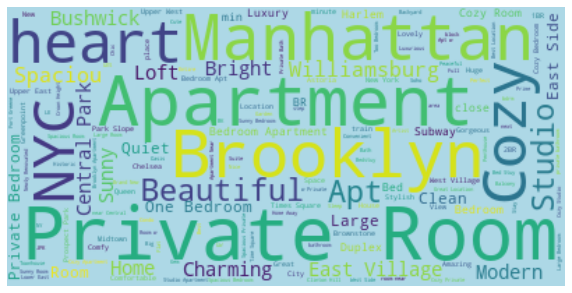

In [59]:
#word cloud
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in preprocessed_df.name)
wordcloud = WordCloud(max_words=200, background_color="lightblue").generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
pass

We see that the most common words used are the names of the boroughs, neighbourhoods, property types as well as adjectives to describe their properties such as "cozy", "charming", "modern", etc. 

This most probably serves to provide potential guests all the information about the property at glance which makes things easier for them and therefore could possibly lead to an increase in booking activity. 

### Now let's graph the relationship between examine the relationship between reviews per month as well as reviews per month (ltm) and yield. 

Up until now, we have used number of reviews to support the analysis of other features vs yield. Now, we plot reviews per month and reviews per month (ltm) to gain insights as to how they affect the revenue. 

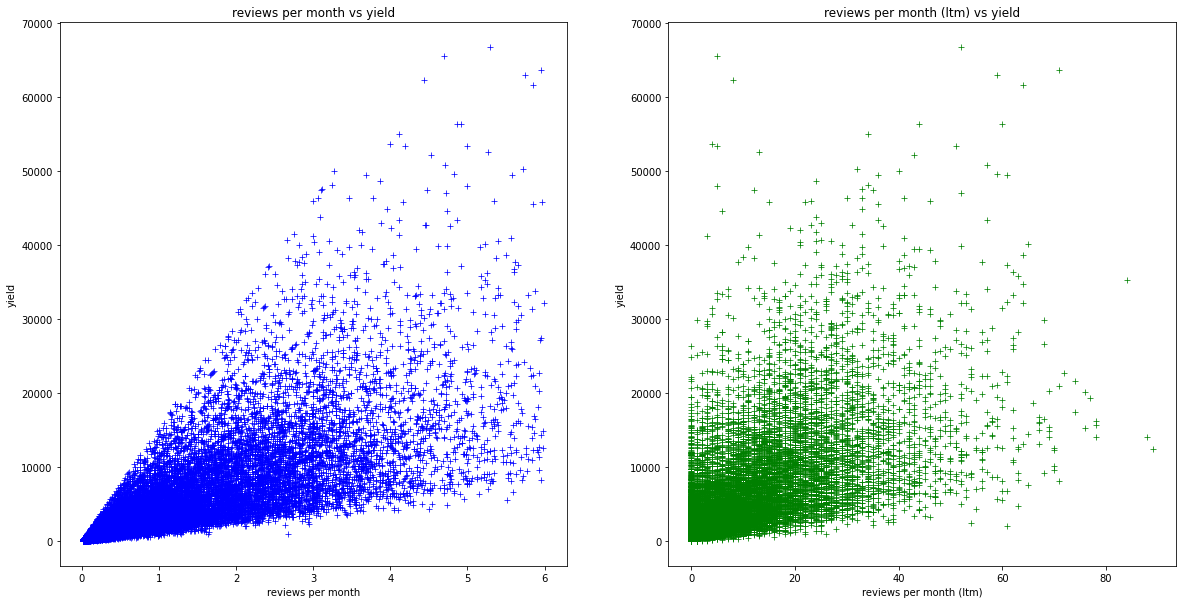

In [60]:
f,ax=plt.subplots(1,2,figsize=(20,10))
ax[0].set_title("reviews per month vs yield")
sns.scatterplot(preprocessed_df["reviews_per_month"], preprocessed_df["yield"], ax=ax[0], marker="+", color="b")
ax[0].set_xlabel('reviews per month')
ax[1].set_title("reviews per month (ltm) vs yield")
sns.scatterplot(preprocessed_df["number_of_reviews_ltm"], preprocessed_df["yield"], ax=ax[1], marker="+",  color="g")
ax[1].set_xlabel('reviews per month (ltm)')
plt.show()

Both graphs give two important insights. First, the distributions of the said features are **highly skewed** in the data set and we can see a **high concentration in the lower values**. 

Second, both graphs clearly illustrate a **linear** relationship between the features and yield, confirming that higher the number of reviews, higher the yield. 

### Now, we investigate the relationship between the accommodates as well as accomodates features with the yield. 

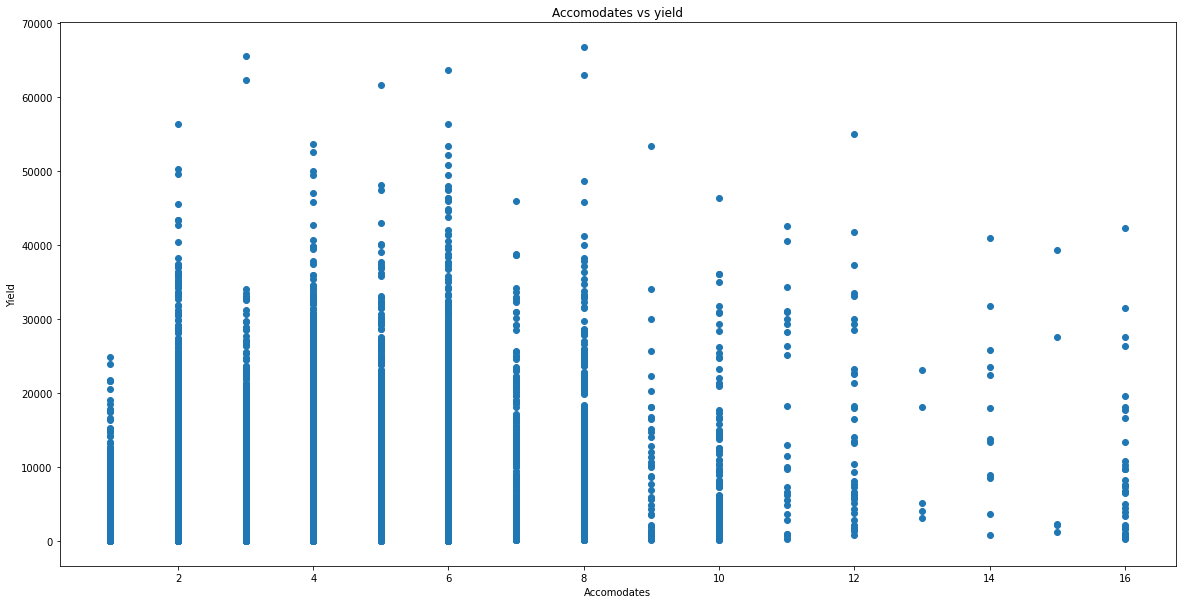

In [61]:
plt.figure(figsize=(20,10))
plt.title("Accomodates vs yield")
plt.scatter(data=preprocessed_df, x="accommodates", y="yield")
plt.xlabel('Accomodates')
plt.ylabel('Yield')
plt.show()

Even though we know that the number of people that a property can accommodate will obviously affect its earning potential, here we can see that there is **no clear relationship** between accomodates and yield. 

For example, we see that properties that can accomodate 6 people have both a lower as well as a higher yield than properties which accommodate 8. 

This may be because even though a property can accomodate a lot of people, potential guests may not be travelling in large groups and thus would go for listings that can accommodate fewer people. The opposite is also possible since a large group of travellers will most likely want to book a listing that can accommodate a lot of people.

### Now, we investigate the relationship between bedrooms as well as bathrooms with the yield.

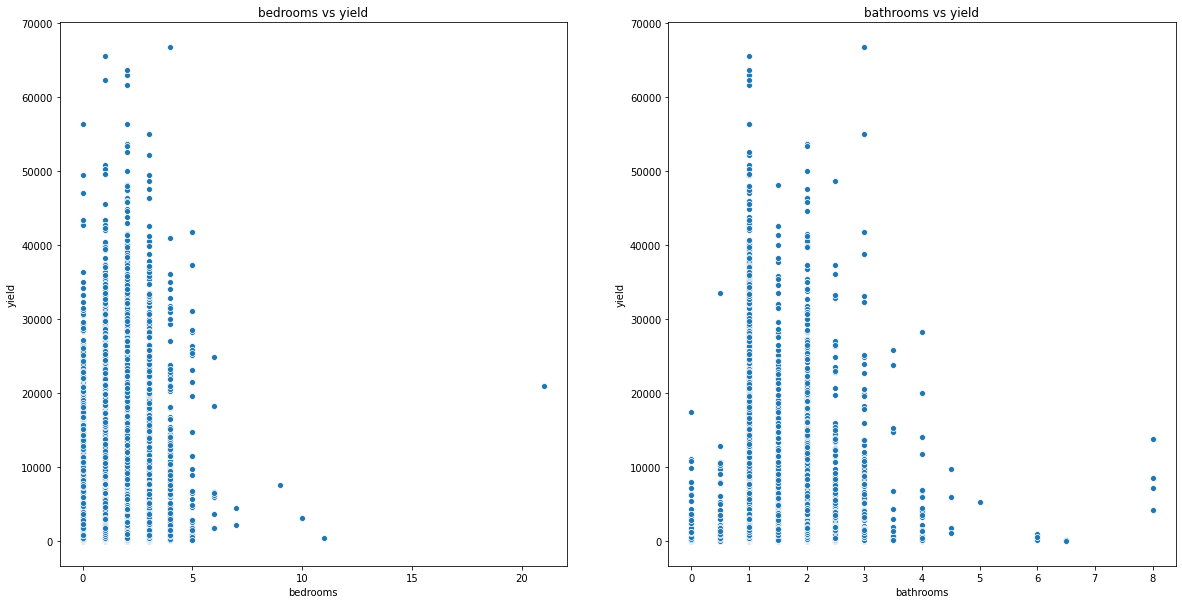

In [62]:
f,ax=plt.subplots(1,2,figsize=(20,10))
ax[0].set_title("bedrooms vs yield")
sns.scatterplot(data=preprocessed_df, x="bedrooms", y="yield",ax=ax[0])
ax[0].set_xlabel('bedrooms')
ax[1].set_title("bathrooms vs yield")
sns.scatterplot(preprocessed_df["bathrooms_text"], preprocessed_df["yield"], ax=ax[1])
ax[1].set_xlabel('bathrooms')
plt.show()

Just like in the case of accomodations discussed earlier, here as well there is **no clear relationship** between both bedrooms or bathrooms and yield.

Obviously the number of bedrooms and bathrooms do affect the price of the listing but potential guests may or may not be travelling in large groups and would choose a property depending on that.

For example, we see that properties that with 4 bedrooms have both a lower as well as a higher yield than properties with 5 bedrooms.

Similarly, we also see that properties that with 3 bathrooms have both a lower as well as a higher yield than properties with 4 bathrooms.

Therefore, 'accommodates', 'bathrooms' and 'bedrooms' do not have a very high predictive power in this case but they are certainly important factors and thus must be used in conjunction with other features. This is exactly what is going to happen next when we use machine learning.

# C. Machine Learning
In this section, we
1. Perform **one-hot encoding** of categorical features and rename the columns. 


2. Perform both **cross-validation** and **Hold-out testing** for 3 models. 

    a. **Linear Regression**. 

    b. **Decision Tree**. 

    c. **Random Forest**.
    

3.  Analyse the models' performance: 

    a. **Mean Squared Error (MSE) loss** and **variance score (r^2)**
    
    b. Visualize and discuss **feature importance** 

### Now, we perform one-hot encoding. 
This is necessary because machine learning algorithms **cannot handle categorical features and only take in numerical data**. 

1. 'neighbourhood_group_cleansed' - Each of the 5 boroughs are assigned a number: **"Manhattan":4, "Brooklyn":3, "Queens":2, "Bronx":1, "Staten Island":0**


2. 'host_has_profile_pic' - First **string values "f" and "t" are coverted to boolean "False" and "True"**, then one-hot encoding is performed: **0 is False and 1 is True**


3. 'host_identity_verified' - First **string values "f" and "t" are coverted to boolean "False" and "True"**, then one-hot encoding is performed: **0 is False and 1 is True**


4. 'instant_bookable' - First **string values "f" and "t" are coverted to boolean "False" and "True"**, then one-hot encoding is performed: **0 is False and 1 is True**


5. 'host_is_superhost' - First **string values "f" and "t" are coverted to boolean "False" and "True"**, then one-hot encoding is performed: **0 is False and 1 is True** 


6. 'room_type' - Each of the 4 room types are assigned a number: **"Entire home/apt":3, "Private room":2, "Shared room":1 and "Hotel room":0**. 



We also rename the columns and create a new dataframe: **preprocessed_df2** which is used for our models 

In [63]:
b={"Manhattan":4,"Brooklyn":3,"Queens":2,"Bronx":1,"Staten Island":0}
preprocessed_df['neighbourhood_group_cleansed'] = preprocessed_df['neighbourhood_group_cleansed'].map(b).astype(int)

#Converting columns from string to boolean and one-hot encoding: 0 is f and 1 is t.
d = {'f': False, 't': True}
preprocessed_df['host_has_profile_pic'] = preprocessed_df['host_has_profile_pic'].map(d).astype(int)
preprocessed_df['host_identity_verified'] = preprocessed_df['host_identity_verified'].map(d).astype(int)
preprocessed_df['instant_bookable'] = preprocessed_df['instant_bookable'].map(d).astype(int)
preprocessed_df['host_is_superhost'] = preprocessed_df['host_is_superhost'].fillna("f").map(d).astype(int)

#room_type one-hot encoding: 3 is Entire home/apt, 2 is Private room, 1 is shared room and 0 is hotel room.
r = {"Entire home/apt":3,"Private room":2,"Shared room":1,"Hotel room":0}
preprocessed_df['room_type'] = preprocessed_df['room_type'].map(r).astype(int)

#renaming columns and creating a new dataframe
preprocessed_df2 = preprocessed_df.rename(columns={"host_since":"years active","host_response_time":"host response time","host_response_rate":"host response rate","host_is_superhost":"superhost","host_has_profile_pic":"profile photo","host_identity_verified":"identity verified","neighbourhood_group_cleansed":"borough","bathrooms_text":"bathrooms","minimum_nights":"minimum nights","maximum_nights":"maximum nights","availability_365":"annual availability","number_of_reviews":"no of reviews","number_of_reviews_ltm":"no of reviews ltm","review_scores_rating":"review scores rating","review_scores_accuracy":"review scores accuracy","instant_bookable":"instantly bookable","reviews_per_month":"reviews per month","amenities_count":"no. of amenities","bath_type":"bathroom type","host_verifications_count":"host verifications count","room_type":"room type"})
preprocessed_df2.drop('name',axis='columns', inplace=True)
preprocessed_df2.head()

,years active,host response time,host response rate,superhost,profile photo,identity verified,borough,latitude,longitude,room type,...,no of reviews ltm,review scores rating,review scores accuracy,instantly bookable,reviews per month,no. of amenities,bathroom type,host verifications count,long term stays,yield
id,,,,,,,,,,,,,,,,,,,,,
2595,12.0,24,83,0,1,1,4,40.75362,-73.98377,3,...,1,94.0,9.0,0,0.37,31,0,9,1,2486.400
3831,12.0,1,94,0,1,1,3,40.68514,-73.95976,3,...,69,89.0,8.0,0,4.82,35,0,6,1,14066.688
5121,11.0,72,0,0,1,1,3,40.68688,-73.95596,2,...,1,90.0,8.0,0,0.36,4,0,8,1,829.440
5136,11.0,12,100,0,1,0,3,40.66120,-73.99423,3,...,0,97.0,10.0,0,0.01,10,0,3,1,67.200
5178,11.0,12,100,0,1,0,4,40.76489,-73.98493,2,...,29,84.0,9.0,0,3.42,18,0,4,0,10374.912


### Now, we plot a correlation matrix to visualize the relationship between the features in our dataset. 

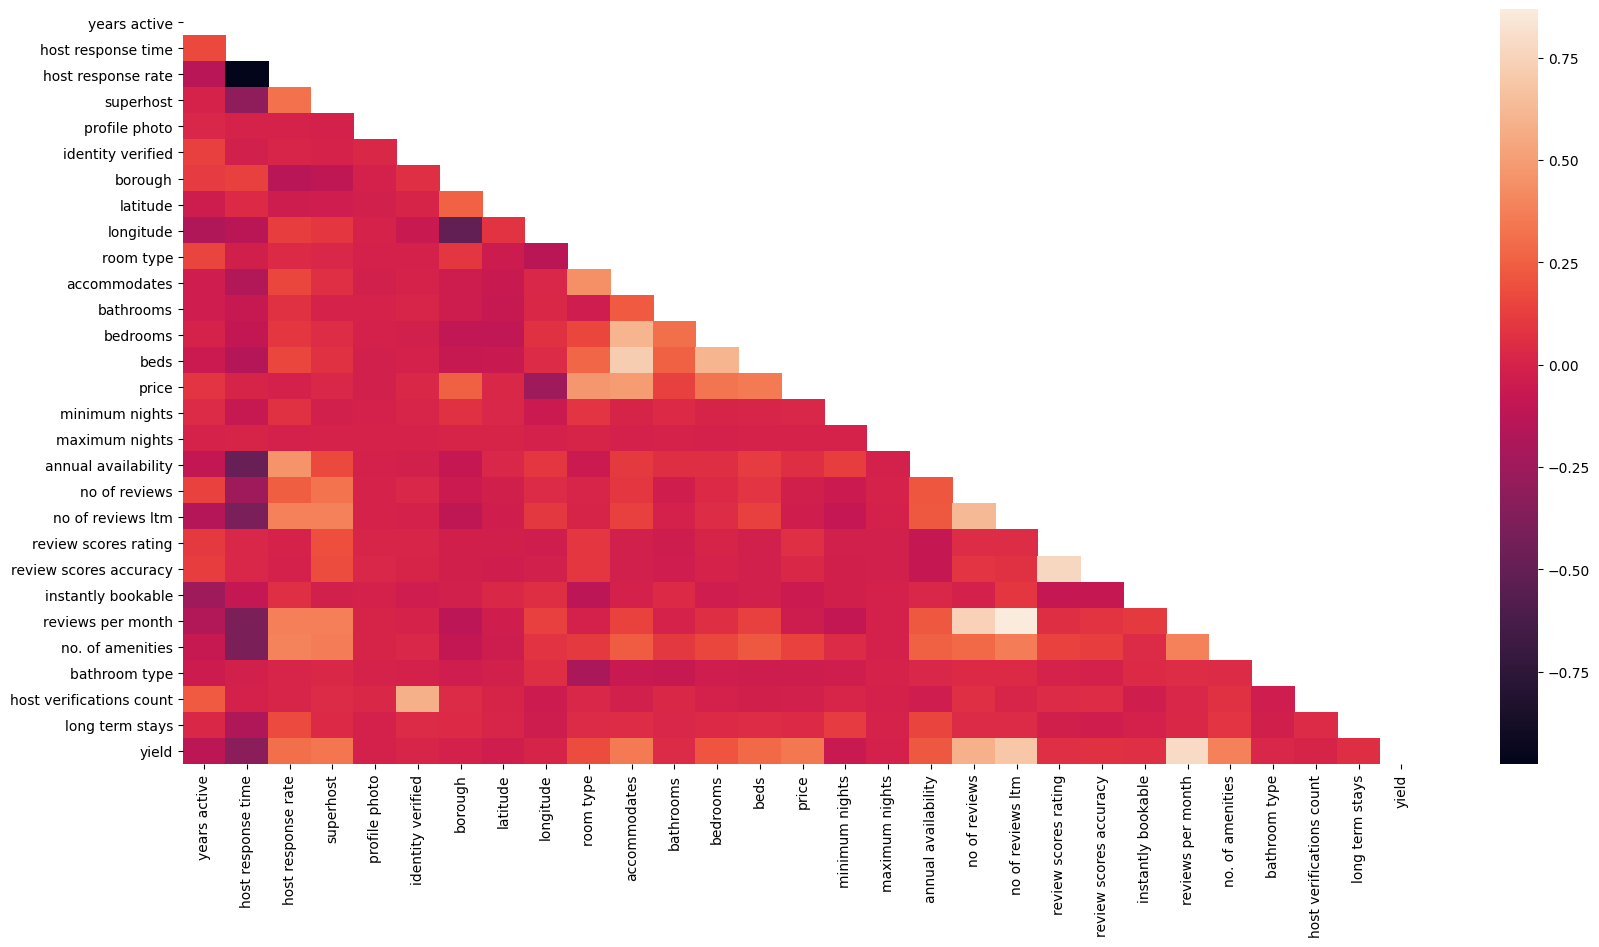

In [64]:
cor = preprocessed_df2.corr(method='pearson')
plt.figure(figsize=(20, 10),dpi=100)
sns.heatmap(data=cor, mask=np.triu(np.ones_like(cor,dtype=np.bool)))
plt.show()

### We now categorize the features based on their correlation with yield

In [65]:
# level the features w.r.t. the correlation with yield

features_list1 = list(preprocessed_df2)

i = 0
gp = []
p = []
n = []

# set threshold for different levels of correlation
for data in cor['yield']:
    if data==1:
        continue
    if data>0.5:
        gp.append(features_list1[i])
    elif data>0:
        p.append(features_list1[i])
    else:
        n.append(features_list1[i])
    i = i+1

# set each list to have the same length to fit into the DataFrame
length = np.max([len(gp), len(p), len(n)])
for i in range(length):
    if i>=len(gp):
        gp.append('')
    if i>=len(p):
        p.append('')
    if i>=len(n):
        n.append('')

df_features = pd.DataFrame()
df_features['greatly positively correlated'] = gp
df_features['positively correlated'] = p
df_features['negatively correlated'] = n
df_features

,greatly positively correlated,positively correlated,negatively correlated
0,no of reviews,host response rate,years active
1,no of reviews ltm,superhost,host response time
2,reviews per month,identity verified,profile photo
3,,longitude,borough
4,,room type,latitude
5,,accommodates,minimum nights
6,,bathrooms,maximum nights
7,,bedrooms,
8,,beds,
9,,price,


From above, we can see **which features are positively or negatively correlated** with yield. 

### Now we begin training and evaluating the models. 

In this section we perform both cross-validation and hold-out testing. 

For both cases, we **remove yield from the training data** as it is the output variable. We **also remove price and reviews per month** as they were used to calculate the yield and therefore have a very strong correlation with it. 

**Cross-validation** (k value = 10: 

Early on during data preprocessing, we had removed outliers from the dataset (rows with price < 400 and reviews per month <6). 

Sometimes removing outliers and thus reducing the dataset can negatively affect the model's performance. **We use cross-validation to check whether the models perform better with or without outliers and if outliers are removed then exactly how much data do we remove**. 

Specifically **we see what percent (from 96% to 100%) of the original data gives us the best results**. Of course in addition to this, cross-validation also serves to evaluate the models. 

**We perfrom cross-validation 4 times**:

    a. Remove outliers for the price feature and evaluate r2 score.
    
    b. Remove outliers for the price feature and evaluate MSE.
    
    c. Remove outliers for the reviews per month feature and evaluate r2 score.
    
    d. Remove outliers for the reviews per month feature and evaluate MSE score.

**Hold-out test**:

We also perform hold-out testing of each of the 3 models are **trained for 10 epochs** with a **70:30 train-test split** using the ideal percentage of the dataset that we found using cross-validation. 

The metrics we use are **Mean Squared Error (MSE) Loss and r-squared (r^2) variance score**. 

1. MSE: It measures the **average of the square of the errors between the actual and predicted yield**. MSE is a commonly used error score for regression models and allows for an intuitive measure of error i.e. **an MSE of 10000 indicates the yield predicted by the model is off by USD 100** (square root of 10000). It is **always non-negative** and **values closer to zero are better**. 


2. r^2 score: It is a statistical measure of how close the data is to the fitted regression line. It is a percentage measure and higher the value, the better the model fits the data. **0% means the model explains none of the variability in the dataset** while **100% means it explains all of it**. 

### For cross-validation, we have to use the original data (without removing outliers) but before that, we need to perform one-hot encoding on it. 

In [66]:
df.drop('name', axis='columns', inplace=True)
b={"Manhattan":4,"Brooklyn":3,"Queens":2,"Bronx":1,"Staten Island":0}
df['neighbourhood_group_cleansed'] = df['neighbourhood_group_cleansed'].map(b).astype(int)

#Converting columns from string to boolean and one-hot encoding: 0 is f and 1 is t.
d = {'f': False, 't': True}
df['host_has_profile_pic'] = df['host_has_profile_pic'].map(d).astype(int)
df['host_identity_verified'] = df['host_identity_verified'].map(d).astype(int)
df['instant_bookable'] = df['instant_bookable'].map(d).astype(int)
df['host_is_superhost'] = df['host_is_superhost'].fillna("f").map(d).astype(int)

#room_type one-hot encoding: 3 is Entire home/apt, 2 is Private room, 1 is shared room and 0 is hotel room.
r = {"Entire home/apt":3,"Private room":2,"Shared room":1,"Hotel room":0}
df['room_type'] = df['room_type'].map(r).astype(int)

#renaming columns and creating a new dataframe
df_cross = df.rename(columns={"host_since":"years active","host_response_time":"host response time","host_response_rate":"host response rate","host_is_superhost":"superhost","host_has_profile_pic":"profile photo","host_identity_verified":"identity verified","neighbourhood_group_cleansed":"borough","bathrooms_text":"bathrooms","minimum_nights":"minimum nights","maximum_nights":"maximum nights","availability_365":"annual availability","number_of_reviews":"no of reviews","number_of_reviews_ltm":"no of reviews ltm","review_scores_rating":"review scores rating","review_scores_accuracy":"review scores accuracy","instant_bookable":"instantly bookable","reviews_per_month":"reviews per month","amenities_count":"no. of amenities","bath_type":"bathroom type","host_verifications_count":"host verifications count","room_type":"room type"})

### Now, performing cross-validation for performance evaluation by removing outlier values in 'price' feature 

In [67]:
# using cross-validation  
score_linear_p = []
score_tree_p = []
score_forest_p = []
pct = []
regression_model = linear_model.LinearRegression()
decision_tree = DecisionTreeRegressor(max_depth=5)
random_forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10, 
                                   max_features='auto', min_samples_split=4, n_estimators=150)
for percent in range(8):
    
    if percent == 0:
        preprocessed_df_eval = df_cross
    elif percent == 1:
        preprocessed_df_eval = df_cross[df_cross["price"]<1000]
    else :
        preprocessed_df_eval = df_cross[df_cross["price"]<(650-50*percent)]
        
    p = preprocessed_df_eval["price"].count()/df_cross["price"].count()
    pct.append(p)
    print("\nPercentage of the dataset retained: ", p)
    X = preprocessed_df_eval.drop(['yield','price','reviews per month'], axis=1)
    Y = preprocessed_df_eval['yield']
    
    #Linear regression
    scores = cross_val_score(regression_model, X, Y, cv=10, scoring='r2')
    print(" r2 scores for linear regression: ",scores.mean())
    score_linear_p.append(scores.mean())
    #Decision Tree
    scores = cross_val_score(decision_tree, X, Y, cv=10, scoring='r2')
    print(" r2 scores for decision tree: ",scores.mean())
    score_tree_p.append(scores.mean())
    #Random Forest
    scores = cross_val_score(random_forest, X, Y, cv=10, scoring='r2')
    print(" r2 scores for random forest: ",scores.mean())
    score_forest_p.append(scores.mean())


Percentage of the dataset retained:  1.0
 r2 scores for linear regression:  0.39512327699231803
 r2 scores for decision tree:  0.389298883756516
 r2 scores for random forest:  0.48821106821663995

Percentage of the dataset retained:  0.9956478268540846
 r2 scores for linear regression:  0.5077967157540069
 r2 scores for decision tree:  0.46077652296881116
 r2 scores for random forest:  0.62374730188816

Percentage of the dataset retained:  0.9850026465917779
 r2 scores for linear regression:  0.5427587515832658
 r2 scores for decision tree:  0.5113861108403512
 r2 scores for random forest:  0.6428299317907948

Percentage of the dataset retained:  0.9812680115273775
 r2 scores for linear regression:  0.5492505003174084
 r2 scores for decision tree:  0.5477968355771206
 r2 scores for random forest:  0.6527854541797875

Percentage of the dataset retained:  0.9765041463271188
 r2 scores for linear regression:  0.5583251070394784
 r2 scores for decision tree:  0.5627564684611791
 r2 scores

In [68]:
# using crossvalidation 
mse_score_linear_p = []
mse_score_tree_p = []
mse_score_forest_p = []
pct = []
regression_model = linear_model.LinearRegression()
decision_tree = DecisionTreeRegressor(max_depth=5)
random_forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10, 
                                   max_features='auto', min_samples_split=4, n_estimators=150)
for percent in range(8):
 
    if percent == 0:
        preprocessed_df_eval = df_cross
    elif percent == 1:
        preprocessed_df_eval = df_cross[df_cross["price"]<1000]
    else :
        preprocessed_df_eval = df_cross[df_cross["price"]<(650-50*percent)]
        
    p = preprocessed_df_eval["price"].count()/df_cross["price"].count()
    pct.append(p)
    print("\nPercentage of the dataset retained: ", p)
    X = preprocessed_df_eval.drop(['yield','price','reviews per month'], axis=1)
    Y = preprocessed_df_eval['yield']
    
    #Linear regression
    scores = cross_val_score(regression_model, X, Y, cv=10, scoring='neg_mean_squared_error')
    print(" MSE scores for linear regression: ",scores.mean()*(-1))
    mse_score_linear_p.append(scores.mean()*(-1))
    #Decision Tree
    scores = cross_val_score(decision_tree, X, Y, cv=10, scoring='neg_mean_squared_error')
    print(" MSE scores for decision tree: ",scores.mean()*(-1))
    mse_score_tree_p.append(scores.mean()*(-1))
    #Random Forest
    scores = cross_val_score(random_forest, X, Y, cv=10, scoring='neg_mean_squared_error')
    print(" MSE scores for random forest: ",scores.mean()*(-1))
    mse_score_forest_p.append(scores.mean()*(-1))


Percentage of the dataset retained:  1.0
 MSE scores for linear regression:  76158775.49345534
 MSE scores for decision tree:  79595734.95877233
 MSE scores for random forest:  72641762.53217827

Percentage of the dataset retained:  0.9956478268540846
 MSE scores for linear regression:  28844255.187502515
 MSE scores for decision tree:  33413400.305828847
 MSE scores for random forest:  24068749.080121156

Percentage of the dataset retained:  0.9850026465917779
 MSE scores for linear regression:  22852500.35097338
 MSE scores for decision tree:  26521291.102995276
 MSE scores for random forest:  19474121.21562404

Percentage of the dataset retained:  0.9812680115273775
 MSE scores for linear regression:  21138652.33479149
 MSE scores for decision tree:  21980652.40534443
 MSE scores for random forest:  17813463.65930553

Percentage of the dataset retained:  0.9765041463271188
 MSE scores for linear regression:  19778989.772558786
 MSE scores for decision tree:  20431941.0121672
 MSE s

### Now we plot the models' performance after cross-validation and removing outlier values for the price feature.

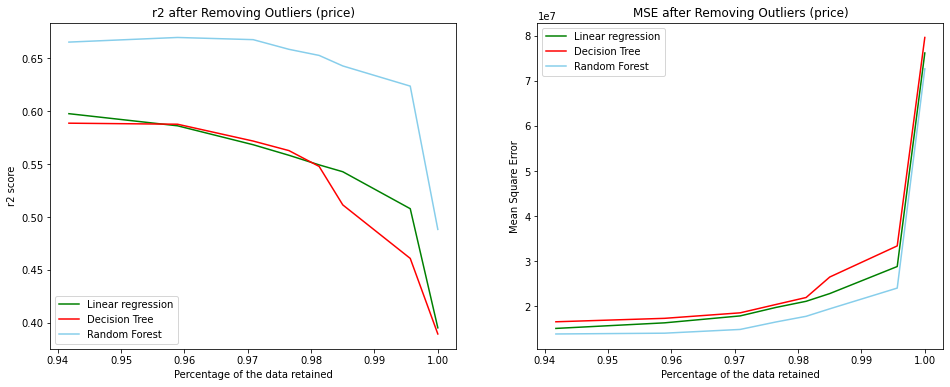

In [69]:
f,ax=plt.subplots(1,2,figsize=(16,6))
ax[0].plot(pct, score_linear_p, color='green', label='Linear regression')
ax[0].plot(pct, score_tree_p, color='red', label='Decision Tree')
ax[0].plot(pct, score_forest_p,  color='skyblue', label='Random Forest')
ax[0].set_title('r2 after Removing Outliers (price)')
ax[0].set_xlabel('Percentage of the data retained')
ax[0].set_ylabel('r2 score')
ax[0].legend()

ax[1].plot(pct, mse_score_linear_p, color='green', label='Linear regression')
ax[1].plot(pct, mse_score_tree_p, color='red', label='Decision Tree')
ax[1].plot(pct, mse_score_forest_p,  color='skyblue', label='Random Forest')
ax[1].set_title('MSE after Removing Outliers (price)')
ax[1].set_xlabel('Percentage of the data retained')
ax[1].set_ylabel('Mean Square Error')
ax[1].legend() 
plt.show()

We see that **there is clear improvement in performance of all 3 models** when we remove the outlier values for the price feature. 

According to the graphs, **the r2 score is maximum with 96%** of the data. We also see that the **MSE score is lowest at 94%, 95% and 96%** of the data. 

### Now, performing cross-validation for performance evaluation by removing outlier values in 'reviews per month' feature 

In [70]:
# using crossvalidation 
score_linear_r = []
score_tree_r = []
score_forest_r = []
pct = []
regression_model = linear_model.LinearRegression()
decision_tree = DecisionTreeRegressor(max_depth=5)
random_forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10, 
                                   max_features='auto', min_samples_split=4, n_estimators=150)
for percent in range(8): 
    if percent == 0:
        preprocessed_df_eval = df_cross
    elif percent == 1:
        preprocessed_df_eval = df_cross[df_cross["reviews per month"]<10]
    else :
        preprocessed_df_eval = df_cross[df_cross["reviews per month"]<(8-0.5*percent)]
        
    p = preprocessed_df_eval["reviews per month"].count()/df_cross["reviews per month"].count()
    pct.append(p)
    print("\nPercentage of the dataset retained: ", p)
    X = preprocessed_df_eval.drop(['yield','price','reviews per month'], axis=1)
    Y = preprocessed_df_eval['yield']
    
    #Linear regression
    scores = cross_val_score(regression_model, X, Y, cv=10, scoring='r2')
    print(" r2 scores for linear regression: ",scores.mean())
    score_linear_r.append(scores.mean())
    #Decision Tree
    scores = cross_val_score(decision_tree, X, Y, cv=10, scoring='r2')
    print(" r2 scores for decision tree: ",scores.mean())
    score_tree_r.append(scores.mean())
    #Random Forest
    scores = cross_val_score(random_forest, X, Y, cv=10, scoring='r2')
    print(" r2 scores for random forest: ",scores.mean())
    score_forest_r.append(scores.mean())


Percentage of the dataset retained:  1.0
 r2 scores for linear regression:  0.39512327699231803
 r2 scores for decision tree:  0.4028030649344248
 r2 scores for random forest:  0.4880333308008019

Percentage of the dataset retained:  0.9987649238369699
 r2 scores for linear regression:  0.4230337270458566
 r2 scores for decision tree:  0.39353687679756855
 r2 scores for random forest:  0.5168969873064698

Percentage of the dataset retained:  0.9956478268540846
 r2 scores for linear regression:  0.4252149794801009
 r2 scores for decision tree:  0.4454131471212074
 r2 scores for random forest:  0.5217210692175456

Percentage of the dataset retained:  0.9945009704169853
 r2 scores for linear regression:  0.4229197499959609
 r2 scores for decision tree:  0.4020687781249871
 r2 scores for random forest:  0.5243507390852805

Percentage of the dataset retained:  0.9926483561724402
 r2 scores for linear regression:  0.4227377735903345
 r2 scores for decision tree:  0.448478373268105
 r2 score

In [71]:
# using crossvalidation  
mse_score_linear_r = []
mse_score_tree_r = []
mse_score_forest_r = []
pct = []
regression_model = linear_model.LinearRegression()
decision_tree = DecisionTreeRegressor(max_depth=5)
random_forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10, 
                                   max_features='auto', min_samples_split=4, n_estimators=150)
for percent in range(8):
    #remove some outliers to see the performance of the three models when remove some outliers.
    #remaining_data/whole_data from 96 percent to 100 percent. 
    if percent == 0:
        preprocessed_df_eval = df_cross
    elif percent == 1:
        preprocessed_df_eval = df_cross[df_cross["reviews per month"]<10]
    else :
        preprocessed_df_eval = df_cross[df_cross["reviews per month"]<(8-0.5*percent)]
        
    p = preprocessed_df_eval["reviews per month"].count()/df_cross["reviews per month"].count()
    pct.append(p)
    print("\nPercentage of the dataset retained: ", p)
    X = preprocessed_df_eval.drop(['yield','price','reviews per month'], axis=1)
    Y = preprocessed_df_eval['yield']
    
    #Linear regression
    scores = cross_val_score(regression_model, X, Y, cv=10, scoring='neg_mean_squared_error')
    print(" MSE scores for linear regression: ",scores.mean()*(-1))
    mse_score_linear_r.append(scores.mean()*(-1))
    #Decision Tree
    scores = cross_val_score(decision_tree, X, Y, cv=10, scoring='neg_mean_squared_error')
    print(" MSE scores for decision tree: ",scores.mean()*(-1))
    mse_score_tree_r.append(scores.mean()*(-1))
    #Random Forest
    scores = cross_val_score(random_forest, X, Y, cv=10, scoring='neg_mean_squared_error')
    print(" MSE scores for random forest: ",scores.mean()*(-1))
    mse_score_forest_r.append(scores.mean()*(-1))


Percentage of the dataset retained:  1.0
 MSE scores for linear regression:  76158775.49345534
 MSE scores for decision tree:  79595734.9587723
 MSE scores for random forest:  72325667.87774853

Percentage of the dataset retained:  0.9987649238369699
 MSE scores for linear regression:  39503612.122076705
 MSE scores for decision tree:  41562614.19393779
 MSE scores for random forest:  34436924.63920603

Percentage of the dataset retained:  0.9956478268540846
 MSE scores for linear regression:  37332176.638286516
 MSE scores for decision tree:  37475326.357792154
 MSE scores for random forest:  32275910.328097235

Percentage of the dataset retained:  0.9945009704169853
 MSE scores for linear regression:  36927634.909852505
 MSE scores for decision tree:  39482885.98579503
 MSE scores for random forest:  31799443.864561558

Percentage of the dataset retained:  0.9926483561724402
 MSE scores for linear regression:  34046338.9687334
 MSE scores for decision tree:  33943927.8554774
 MSE sc

### Now we plot the models' performance after cross-validation and removing outlier values for the 'reviews per month' feature

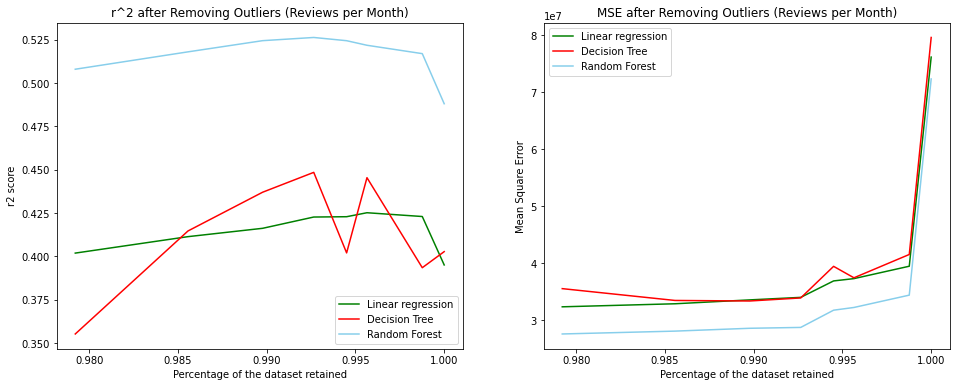

In [72]:
f,ax=plt.subplots(1,2,figsize=(16,6))
ax[0].plot(pct, score_linear_r, color='green', label='Linear regression')
ax[0].plot(pct, score_tree_r, color='red', label='Decision Tree')
ax[0].plot(pct, score_forest_r,  color='skyblue', label='Random Forest')
ax[0].set_title('r^2 after Removing Outliers (Reviews per Month)')
ax[0].set_xlabel('Percentage of the dataset retained')
ax[0].set_ylabel('r2 score')
ax[0].legend()

ax[1].plot(pct, mse_score_linear_r, color='green', label='Linear regression')
ax[1].plot(pct, mse_score_tree_r, color='red', label='Decision Tree')
ax[1].plot(pct, mse_score_forest_r,  color='skyblue', label='Random Forest')
ax[1].set_title('MSE after Removing Outliers (Reviews per Month)')
ax[1].set_xlabel('Percentage of the dataset retained')
ax[1].set_ylabel('Mean Square Error')
ax[1].legend() 
plt.show()

We see that **there is clear improvement in performance of all 3 models** when we remove the outlier values for the 'reviews per month' feature. 

According to the graphs, **the r2 score is maximum with 99.25%** of the data. We also see that the **MSE score is lowest at 98%** of the data. 

### Summarizing cross-validation results: 

Random forest performed best out of the 3 models. 

Now, 

For price - maximum r2 score at 96% of the data and lowest MSE at 94%, 95% and 96% of the data. 

For reviews per month - maximum r2 score at 99.25% of the data and lowest MSE at 98% of the data. 

**In data science and machine learning, the goal should be perform analysis and prediction using the least amount of data**. 

Therefore, **we will use the least percentage value that we have arrived at, which is 96%** 

### As we can observe, we arrived at the exact same percentage value that we had when we first removed the outliers. Thus our reasoning was correct and now we can use the data for hold-out testing of the models.

### Now we perform hold-out testing.

In [74]:
test_size = 0.3
rf_cumulate = np.zeros(26)
dt_cumulate = np.zeros(26)
lr_cumulate = np.zeros(26)
X = preprocessed_df2.drop(['yield','price','reviews per month'], axis=1)
y = preprocessed_df2['yield']

err_forest = []
var_forest = []

err_linear = []
var_linear = []

err_tree = []
var_tree = []

for loop_time in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    linear_regression = LinearRegression()
    decision_tree = DecisionTreeRegressor(max_depth=5)
    random_forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10, 
                               max_features='auto', min_samples_split=4, n_estimators=150)
    
    linear_regression.fit(X_train, y_train)
    linear_regression_y_pred = linear_regression.predict(X_test)
    
    decision_tree.fit(X_train, y_train)
    decision_tree_y_pred = decision_tree.predict(X_test)
    
    random_forest.fit(X_train, y_train)
    random_forest_y_pred = random_forest.predict(X_test)

    lr_mse = mean_squared_error(y_test, linear_regression_y_pred)
    err_linear.append(lr_mse)
    var_linear.append(r2_score(y_test, linear_regression_y_pred))
    
    dt_mse = mean_squared_error(y_test, decision_tree_y_pred)
    err_tree.append(dt_mse)
    var_tree.append(r2_score(y_test, decision_tree_y_pred))
    
    rf_mse = mean_squared_error(y_test, random_forest_y_pred)
    err_forest.append(rf_mse)
    var_forest.append(r2_score(y_test, random_forest_y_pred))
    
    lr_importance = linear_regression.coef_
    lr_cumulate = lr_cumulate+lr_importance
    
    dt_importance = decision_tree.feature_importances_
    dt_cumulate = dt_cumulate+dt_importance
    
    rf_importance = random_forest.feature_importances_
    rf_cumulate = rf_cumulate+rf_importance

### Now, we visualize the loss and variance for all 3 models. 

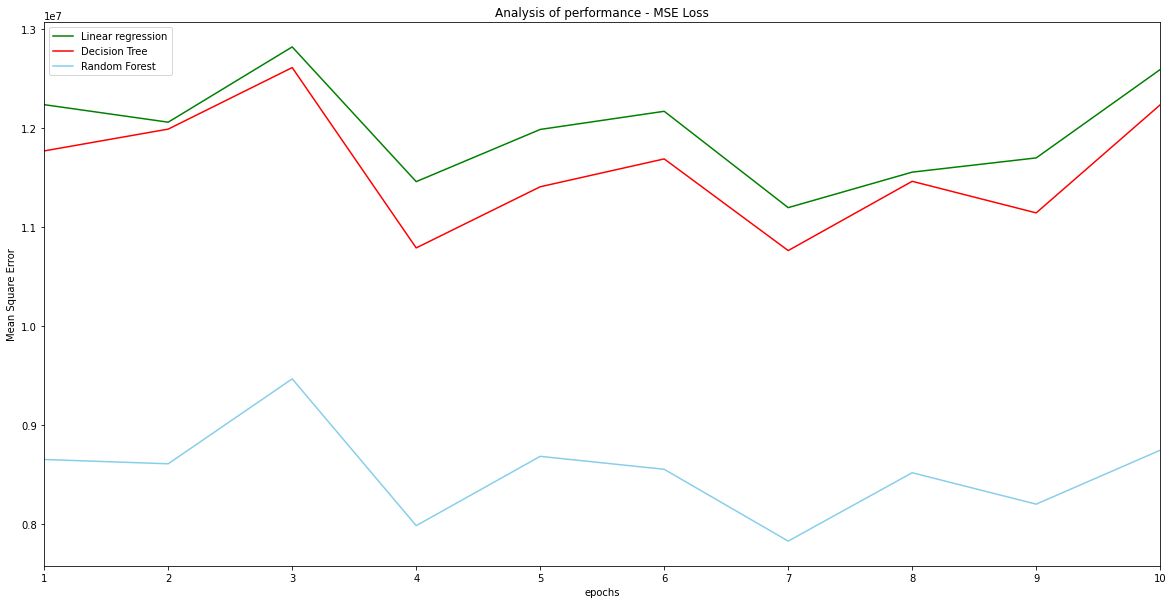

In [76]:
plt.figure(figsize=(20,10))
plt.title('Analysis of performance - MSE Loss')
plt.plot(np.arange(1,11,1.0), err_linear, color='green', label='Linear regression')
plt.plot(np.arange(1,11,1.0), err_tree, color='red', label='Decision Tree')
plt.plot(np.arange(1,11,1.0), err_forest,  color='skyblue', label='Random Forest')
plt.legend() 

plt.xlabel('epochs')
plt.ylabel('Mean Square Error')
plt.xlim(1,10)
plt.show()

### Random forest has the lowest MSE loss for all 10 epochs. 

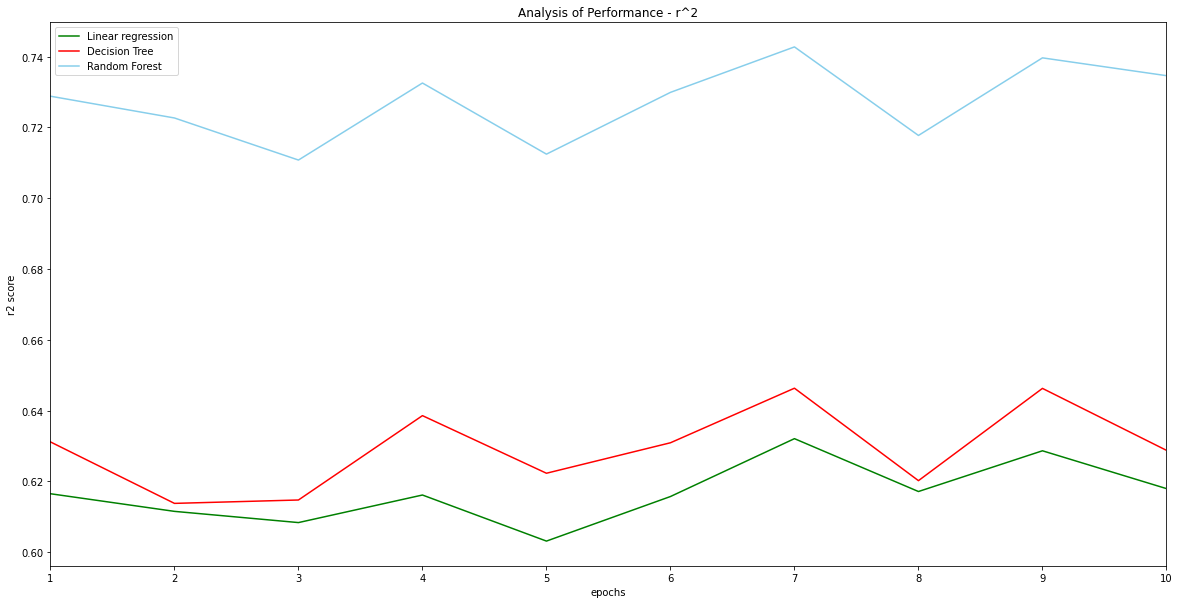

In [77]:
plt.figure(figsize=(20,10))
plt.title('Analysis of Performance - r^2')
plt.plot(np.arange(1,11,1.0), var_linear, color='green', label='Linear regression')
plt.plot(np.arange(1,11,1.0), var_tree, color='red', label='Decision Tree')
plt.plot(np.arange(1,11,1.0), var_forest,  color='skyblue', label='Random Forest')
plt.legend() 

plt.xlabel('epochs')
plt.ylabel('r2 score')
plt.xlim(1,10)
plt.show()

### Random forest has the highest r^2 variance score for all 10 epochs. 

In [78]:
metrics = {'Random Forest MSE': err_forest, 'Random Forest r^2': var_forest, 'Decision Tree MSE':err_tree,'Decision Tree r^2':var_tree,'Linear Regression MSE':err_linear,'Linear Regression r^2':var_linear}
performance = pd.DataFrame(data=metrics,index=np.arange(1,11,1))
performance

,Random Forest MSE,Random Forest r^2,Decision Tree MSE,Decision Tree r^2,Linear Regression MSE,Linear Regression r^2
1,8.652884e+06,0.728820,1.177028e+07,0.631122,1.223757e+07,0.616477
2,8.609454e+06,0.722668,1.199060e+07,0.613753,1.206065e+07,0.611496
3,9.467466e+06,0.710778,1.261222e+07,0.614708,1.282113e+07,0.608326
4,7.984326e+06,0.732545,1.079040e+07,0.638548,1.146006e+07,0.616116
5,8.684591e+06,0.712447,1.140808e+07,0.622270,1.198719e+07,0.603095
6,8.553707e+06,0.729902,1.168961e+07,0.630880,1.217065e+07,0.615690
7,7.828395e+06,0.742751,1.076348e+07,0.646301,1.119735e+07,0.632044
8,8.519017e+06,0.717730,1.146329e+07,0.620174,1.155592e+07,0.617104
9,8.201558e+06,0.739657,1.114422e+07,0.646247,1.169969e+07,0.628615
10,8.746486e+06,0.734625,1.223610e+07,0.628747,1.259267e+07,0.617929


We can clearly see that **Random Forest has the lowest MSE and the highest r^2 score**, making it the best performing model. 

In fact, 

1. Random Forest's highest MSE is lower than both Linear Regression's and Decision Tree's lowest MSE. 


2. Random Forest's lowest r^2 score is higher than both Linear Regression's and Decision Tree's highest r^2 score. 


3. We even observed that Random Forest was the best performing model according to cross-validation.


### For further clarity, we graph Random Forest's performance metrics. 

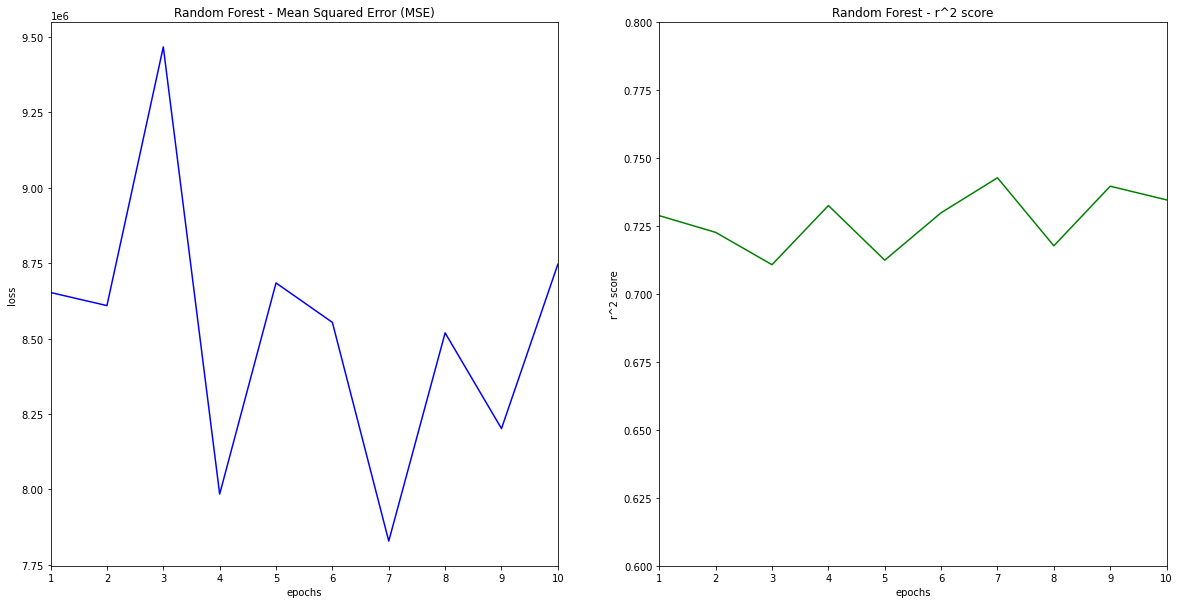

In [79]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.set_title('Random Forest - Mean Squared Error (MSE)')
ax1.plot(np.arange(1,11,1.0), err_forest, color='blue')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_xlim(1,10)
ax2.set_title('Random Forest - r^2 score')
ax2.plot(np.arange(1,11,1.0), var_forest, color='green')
ax2.set_xlabel('epochs')
ax2.set_ylabel('r^2 score')
ax2.set_xlim(1,10)
ax2.set_ylim(0.6,0.8)
plt.show()

### Now, we visualize the feature importance for Random Forest. 

,Feature,Importance
0,years active,0.174540
1,host response time,0.042365
2,host response rate,0.065808
3,superhost,0.015489
4,profile photo,0.000289
5,identity verified,0.009349
6,borough,0.075610
7,latitude,0.220486
8,longitude,0.324162
9,room type,0.692977


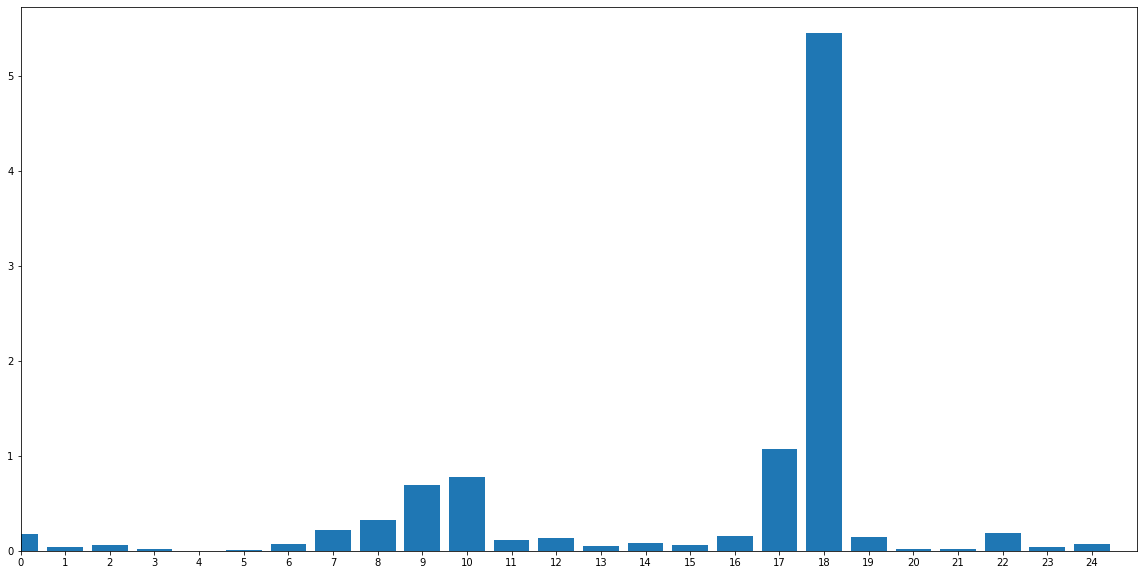

In [80]:
features_list = list(X)
importance_values = []

# summarize feature importance
for i,v in enumerate(rf_cumulate):
    importance_values.append(v)

fi = {'Feature': features_list, 'Importance': importance_values}
feature_importance = pd.DataFrame(data=fi)

for data in rf_cumulate:
    data = data/10
# plot feature importance
plt.figure(figsize=(20,10))
axes = plt.gca()
axes.bar([x for x in range(len(rf_cumulate))], rf_cumulate)
axes.set_xlim(0, 25)
plt.xticks(np.arange(0, 25, 1.0))
axes.plot()

feature_importance.head(30)

### We now rank the features in increasing order of their importance (descending order of the raw importance score value)

In [81]:
feature_importance = feature_importance.sort_values('Importance',ascending=False)
feature_importance.reset_index(drop=True)

,Feature,Importance
0,no of reviews ltm,5.452064
1,no of reviews,1.068879
2,accommodates,0.781416
3,room type,0.692977
4,longitude,0.324162
5,latitude,0.220486
6,no. of amenities,0.186651
7,years active,0.174540
8,annual availability,0.152226
9,review scores rating,0.142201


### This gives us a lot of insight as to why Random Forests worked so well for our data and problem statement. 
Note that most of the features that Random Forest considered to be important **share a positive correlation with yield** as we can see from the correlation matrix that we plotted before. 

We can see that the most important feature is **no of reviews ltm** (ltm: last twelve months) which, according to the correlation matrix, is **greatly positively correlated** with yield. Same is the case for **No. of reviews**. This makes intuitive sense as the number of reviews that a property has received recently (in the past year) and its total lifetime reviews reflect the property's as well as the host's quality which of course is a factor that potential guests take into consideration. 

We can also make out that the algorithm considers **accommodates** and **room type** to be highly important (they are both **positively correlated** with yield). This also makes sense as the number of people a property can accomodate as well as the property's type greatly influence a potential guest's decision to book a listing and therefore has great impact on the earning potential of that property. 

**No. of amenities** is also considered important as well as it is positively correlated. Rightfully so since properties with more amenities would attract more guests as they provide more "bang for the buck". 

All this means that **Random Forest was successfully able to recognize which features have more predictive power** and therefore was able to achieve a low loss value as well as a high variance score. 

### Now, lets graph the feature importance for Linear Regression and Decision Tree. 
This will show us why these models failed to perform well and help us put things into perspective for better understanding the entire prediction process.

### Linear Regression feature importance

,Feature,Importance
0,years active,-2319.255142
1,host response time,-63.080100
2,host response rate,-54.047430
3,superhost,6758.531613
4,profile photo,2119.061284
5,identity verified,3184.846006
6,borough,4401.834274
7,latitude,-3149.803603
8,longitude,-52494.086284
9,room type,9216.937015


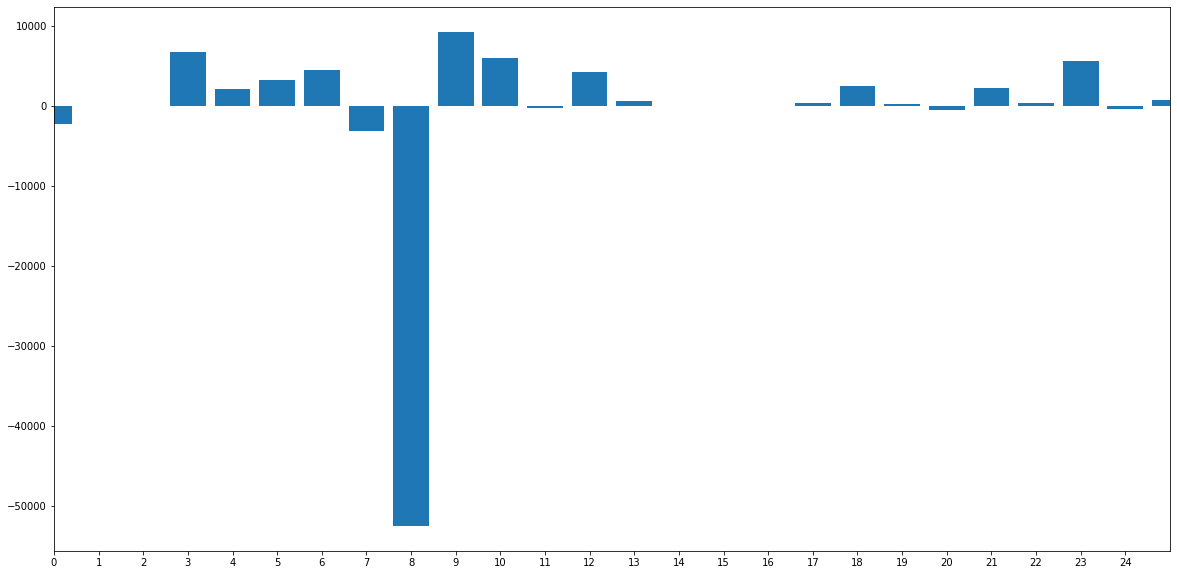

In [82]:
features_listlr = list(X)
importance_valueslr = []

# summarize feature importance
for i,v in enumerate(lr_cumulate):
    importance_valueslr.append(v)

fi = {'Feature': features_listlr, 'Importance': importance_valueslr}
feature_importancelr = pd.DataFrame(data=fi)

for data in lr_cumulate:
    data = data/10
# plot feature importance

plt.figure(figsize=(20,10))
axes = plt.gca()
axes.bar([x for x in range(len(lr_cumulate))], lr_cumulate)
axes.set_xlim(0, 25)
plt.xticks(np.arange(0, 25, 1.0))
axes.plot()

feature_importancelr.head(30)

### We now rank the features in increasing order of their importance (descending order of the raw importance score value)

In [83]:
feature_importancelr = feature_importancelr.sort_values('Importance',ascending=False)
feature_importancelr.reset_index(drop=True)

,Feature,Importance
0,room type,9216.937015
1,superhost,6758.531613
2,accommodates,5986.154838
3,bathroom type,5528.721768
4,borough,4401.834274
5,bedrooms,4149.436858
6,identity verified,3184.846006
7,no of reviews ltm,2440.711071
8,instantly bookable,2205.389889
9,profile photo,2119.061284


### This tells us why Linear Regression performs poorly. 
Note that Linear Regression **failed to give enough importance to features that are greatly positively correlated with yield** We can see that **no of reviews ltm** and **No. of reviews** are given far less importance than they should. 

We can also make out that the algorithm gives more importance to **instantly bookable** and **profile photo** than required.
 
All this means that **Linear Regression was unable to recognize which features have more predictive power** and therefore achieved a high loss value as well as a low variance score. 

### Decision Tree feature importance

,Feature,Importance
0,years active,0.031164
1,host response time,0.000000
2,host response rate,0.000000
3,superhost,0.000000
4,profile photo,0.000000
5,identity verified,0.000000
6,borough,0.032705
7,latitude,0.000000
8,longitude,0.058481
9,room type,0.838399


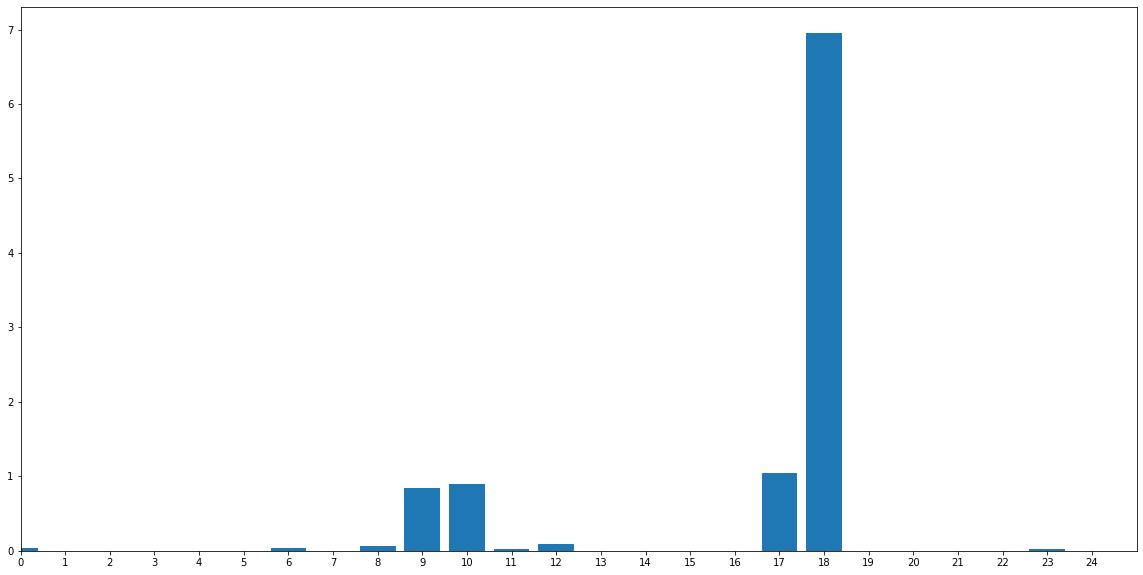

In [84]:
features_listdt = list(X)
importance_valuesdt = []

# summarize feature importance
for i,v in enumerate(dt_cumulate):
    importance_valuesdt.append(v)

fi = {'Feature': features_listdt, 'Importance': importance_valuesdt}
feature_importancedt = pd.DataFrame(data=fi)

for data in dt_cumulate:
    data = data/10
# plot feature importance
plt.figure(figsize=(20,10))
axes = plt.gca()
axes.bar([x for x in range(len(dt_cumulate))], dt_cumulate)
axes.set_xlim(0, 25)
plt.xticks(np.arange(0, 25, 1.0))
axes.plot()

feature_importancedt.head(30)

### We now rank the features in increasing order of their importance (descending order of the raw importance score value)

In [85]:
feature_importancedt = feature_importancedt.sort_values('Importance',ascending=False)
feature_importancedt.reset_index(drop=True)

,Feature,Importance
0,no of reviews ltm,6.952676
1,no of reviews,1.042873
2,accommodates,0.899139
3,room type,0.838399
4,bedrooms,0.096123
5,longitude,0.058481
6,borough,0.032705
7,years active,0.031164
8,bathroom type,0.022955
9,bathrooms,0.020136


### This tells us why Decision Tree performs poorly.
Note that Decision Tree **gives enough importance to some positively correlated features** such as **accomodates, room type, no. of reviews ltm**, etc. 

However, it also **fails to give any importance at all to several other positively correlated features** such as **host response rate, superhost**, etc.

This means that Decision Tree recognizes **some but not most of the features with high predictive power** and therefore, it performs better than Linear Regression but is not as good as Random Forest.

### Finally, we discuss the prediction results for random forests

**Let us see the performance metrics for random forest**.

In [86]:
rf_performance = performance[['Random Forest MSE','Random Forest r^2']]
rf_performance

,Random Forest MSE,Random Forest r^2
1,8.652884e+06,0.728820
2,8.609454e+06,0.722668
3,9.467466e+06,0.710778
4,7.984326e+06,0.732545
5,8.684591e+06,0.712447
6,8.553707e+06,0.729902
7,7.828395e+06,0.742751
8,8.519017e+06,0.717730
9,8.201558e+06,0.739657
10,8.746486e+06,0.734625


Now, we know that we have trained the model for 10 epochs and thus have 10 MSE loss values. 

So let's **take the worst-case scenario, that is, the highest loss value**. 

After that, we get **the average dollar value by which the predicted yield was off**. 

This is done by simply taking the **square root of the loss value**. 

In [87]:
off_value = round(np.sqrt(max(rf_performance['Random Forest MSE'])),2)
off_value

3076.92

In [88]:
print("Therefore, our model's prediction is off by US$", off_value,"or US$", round((off_value/12),2),"per month.")

Therefore, our model's prediction is off by US$ 3076.92 or US$ 256.41 per month.


This of course **can be improved by training for more epochs** and **hyperparameter tuning**.

# D. Final thoughts
This project has been extremely rewarding to complete, giving us a challenging and interesting problem to explore. 
We analyzed the dataset and discussed the impact of various features on properties' yields. In addition, we used machine learning to predict the yield. 

We used multiple plots viz., piecharts, scatterplots, barplots, boxplots, etc., to truly take advantage of visualization libraries (matplotlib as well as seaborn) and gain maximum information. We not only visualised the dataset itself but also the results of all 3 machine learning models and were able to get a deep insight into the models' performance. 

We used pandas to its fullest for data cleaning/preprocessing, successfully incorporating all the components of the course. 